In [11]:
import numpy as np
import pandas as pd
import collections as c
import pickle
import seaborn as sns
sns.reset_defaults
sns.set_style(style='darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [2]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        self.residuals_ = self.results_.outlier_test()['student_resid']
    def fit_regularized(self, X, y, a, l1):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(alpha=a, L1_wt=l1)
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    def summary(self):
        return self.results_.summary()

In [12]:
lin_reg_model = pickle.load(open('../models/linear_regression_score_first_half.p', 'rb')) # load the model

In [13]:
lin_reg_model.get_params

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)>

In [14]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, columns)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)


def only_completed(X_test, y_test, y_test_not_comp):
    '''
    Returns dataframes with only those students who completed the course for the purpose of regressing the final score.
    '''
    test_indices = []
    train_indices = []

    y_test_not_comp = y_test_not_comp[y_test_not_comp['module_not_completed'] == 1]
    for index, row in y_test_not_comp.iterrows():
        test_indices.append(index)

    return X_test.drop(test_indices), y_test.drop(test_indices)

def plot_residuals(stud_resid, target, features, data):
    '''
    Creates scatterplots of residuals against target and specified features
    Parameters:
    ----------
    input {all array-like}: calculated residuals, target values from test data, list of features to plot against
    output {plots}: some plots
    '''
    plt.figure(figsize=(12,10))
    plt.scatter(x=target, y=stud_resid, alpha = 0.1, c='red')
    plt.hlines(0, target.min(), target.max(), 'k', linestyle='dashed')
    plt.ylabel("Residuals")
    plt.xlabel("Target")
    plt.title("Residuals vs. Target")
    plt.show()

    for f in features:
        plt.figure(figsize=(12,10))
        plt.scatter(x=data[f], y=stud_resid, alpha=0.1, c='blue')
        plt.hlines(0,
              data[f].min(), 
              data[f].max(), 
              'k', linestyle='dashed')
        plt.ylabel("Residuals")
        plt.xlabel(f)
        plt.title("Residuals vs {}".format(f))
        plt.show()

In [15]:
#     X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
#     y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
#     y_train_not_comp = y_train[['module_not_completed']]
#     y_train = y_train['estimated_final_score']
    X_test = pd.read_csv('../data/processed/first_half/X_test.csv')
    y_test = pd.read_csv('../data/processed/first_half/y_test.csv')
    y_test_not_comp = y_test[['module_not_completed']]
    y_test = y_test['estimated_final_score']
    
    numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

    # fill and scale
#     X_train.fillna(value = 0, inplace = True)
#     y_train.fillna(value = 0, inplace = True)
#     X_train = scale_subset(X_train, numeric_cols)
    # X_train = sm.add_constant(X_train)
    X_test.fillna(value = 0, inplace = True)
    y_test.fillna(value = 0, inplace = True)
    X_test = scale_subset(X_test, numeric_cols)
    # X_test = sm.add_constant(X_test)

    # only students who completed the course
    X_test, y_test = only_completed(X_test, y_test, y_test_not_comp)
    
    # resolve multicolinearity
    high_vif = ['sum_click_repeatactivity', 'days_early_first_assessment', 'sum_days_vle_accessed', 'module_presentation_length', 'score_first_assessment']
#     X_train.drop(high_vif, axis = 1, inplace = True)
    X_test.drop(high_vif, axis = 1, inplace = True)

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [20]:
# lin_reg_model.summary()

In [21]:
    predictions = lin_reg_model.predict(X_test)
    residuals = predictions - y_test
#     stud_resid = lin_reg_model.residuals_
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    evs = explained_variance_score(y_test, predictions)
    r2 = r2_score(y_test, predictions)

In [22]:
    print('Root Mean Squared Error: {}'.format(rmse))
    print('Target Standard Deviation: {}'.format(np.std(y_test)))
    print('R-Squared: {}'.format(r2))
    print('Explained Variance Score: {}'.format(evs))

Root Mean Squared Error: 11.883950438376793
Target Standard Deviation: 26.404166201517572
R-Squared: 0.797429244268568
Explained Variance Score: 0.7974295255013903


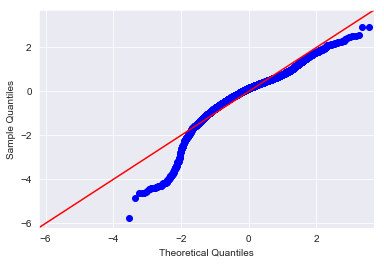

In [28]:
    ax = sm.graphics.qqplot(studentized_residuals, line='45')

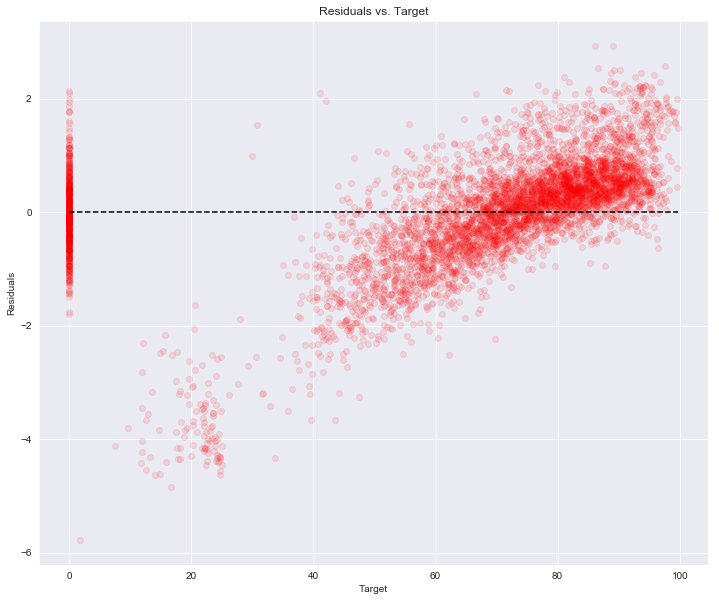

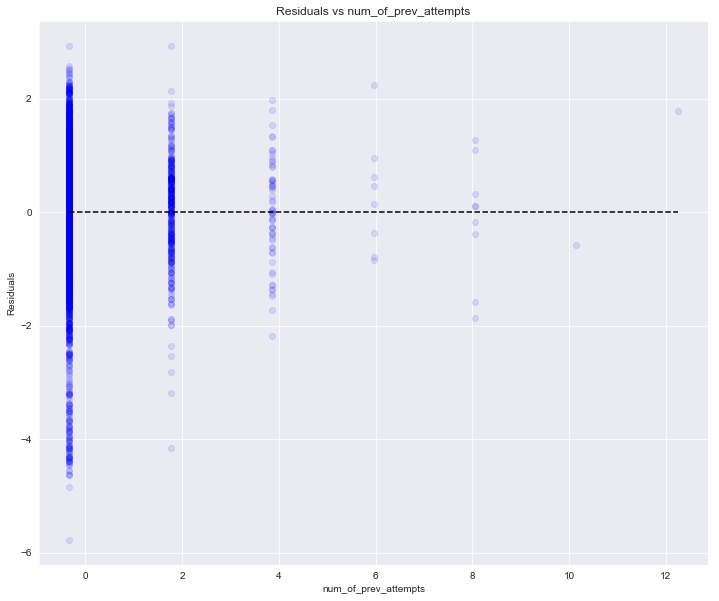

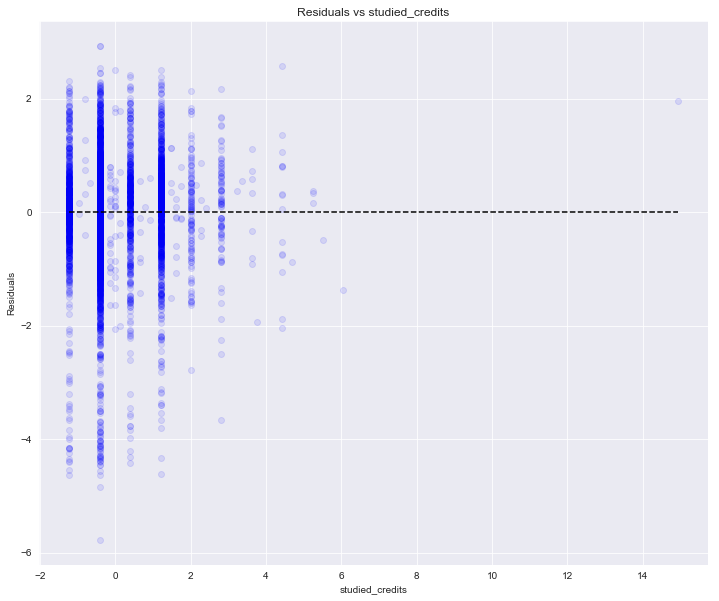

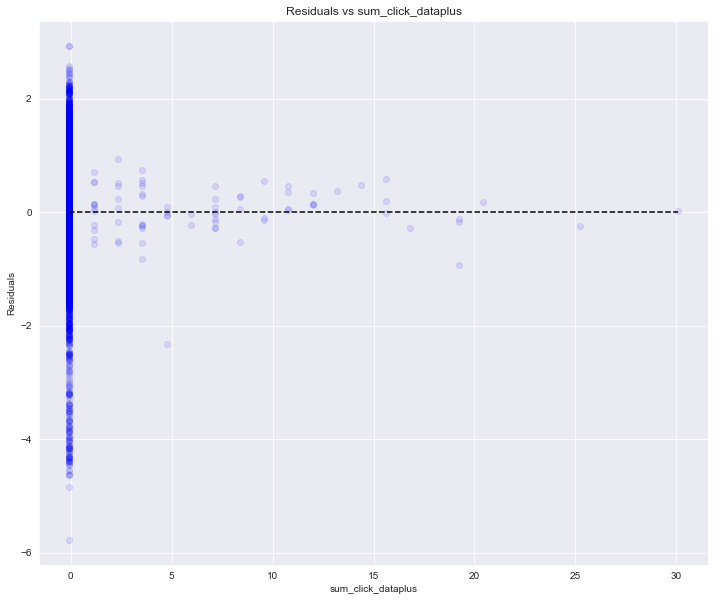

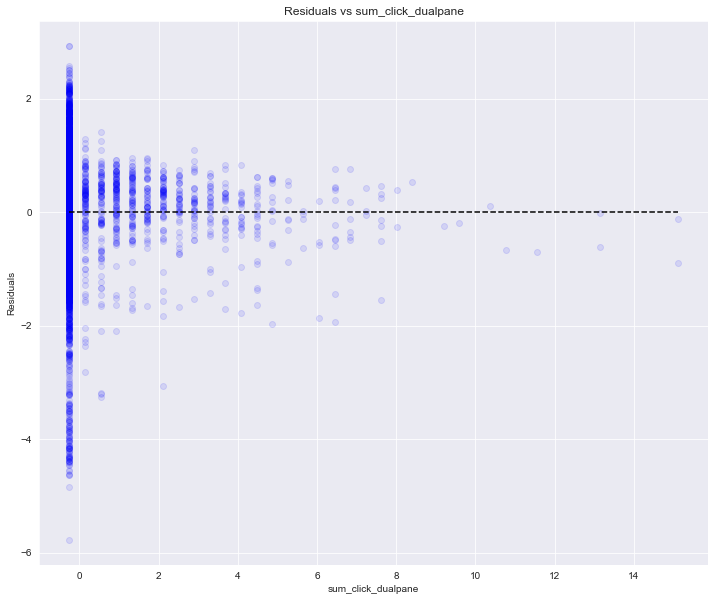

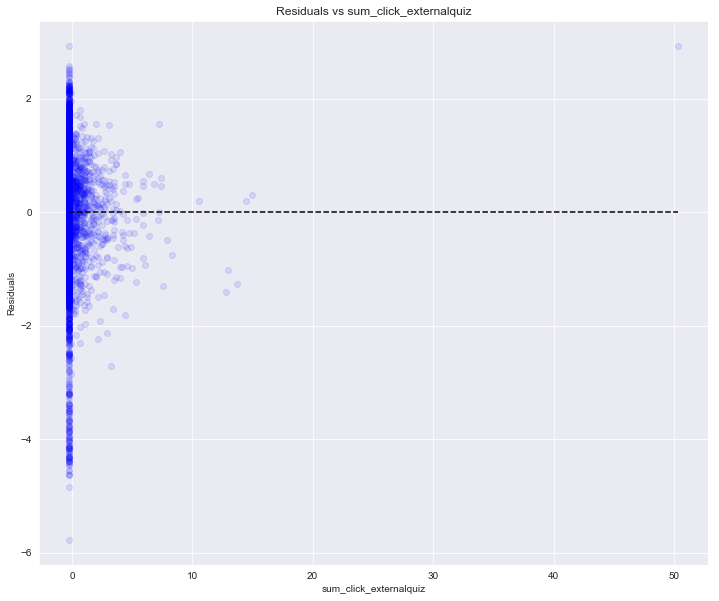

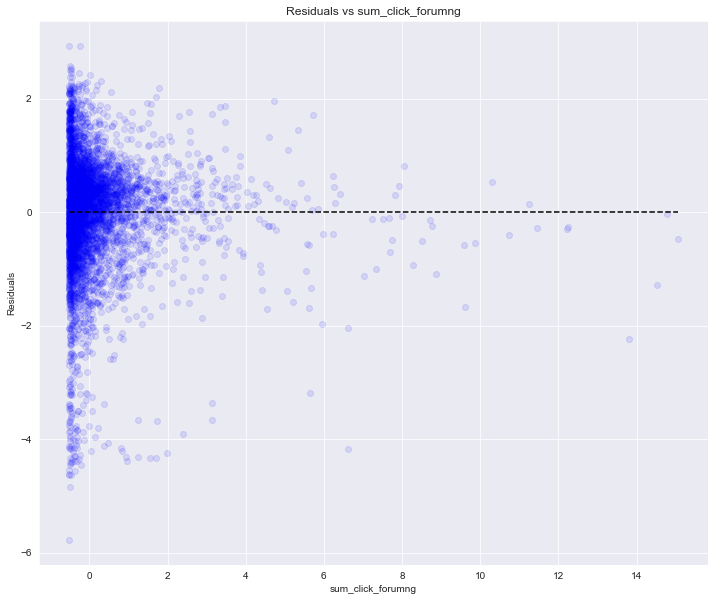

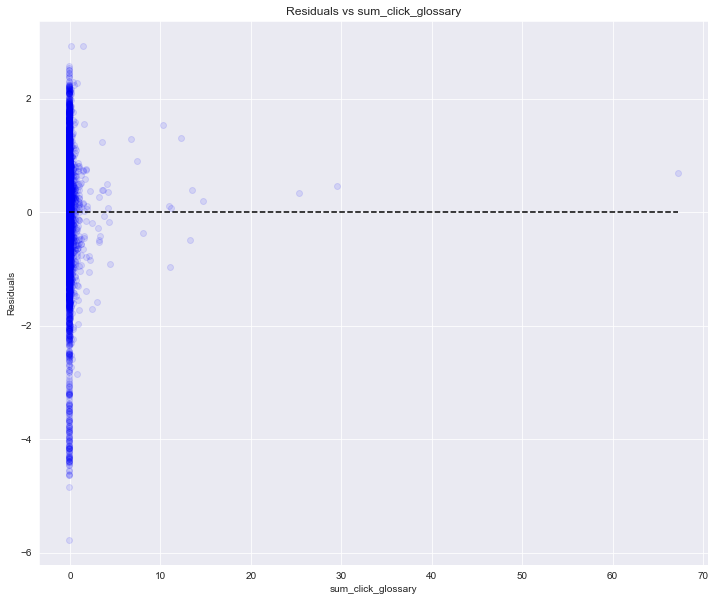

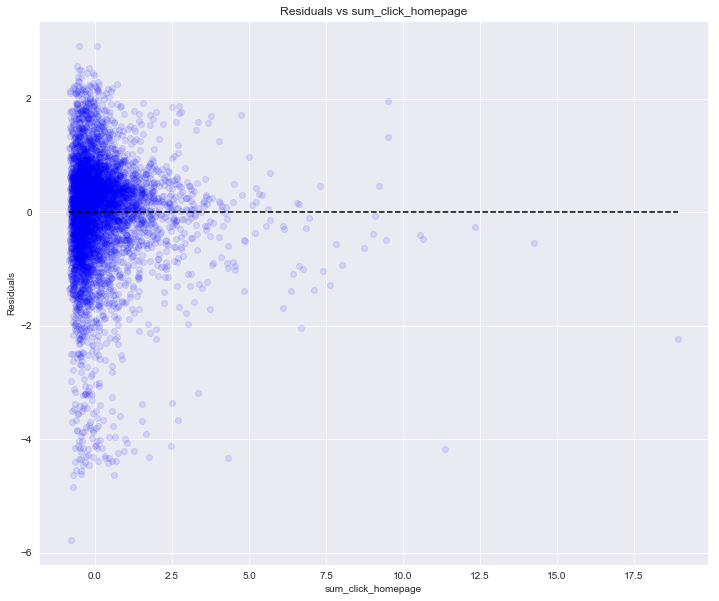

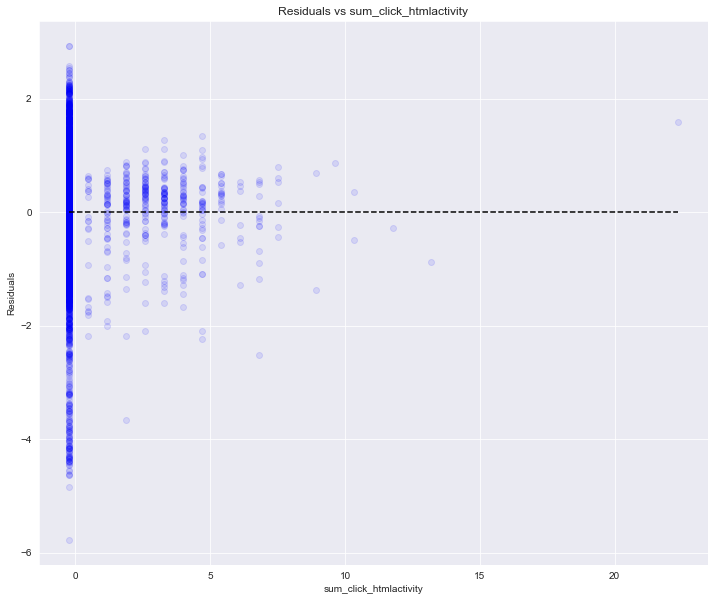

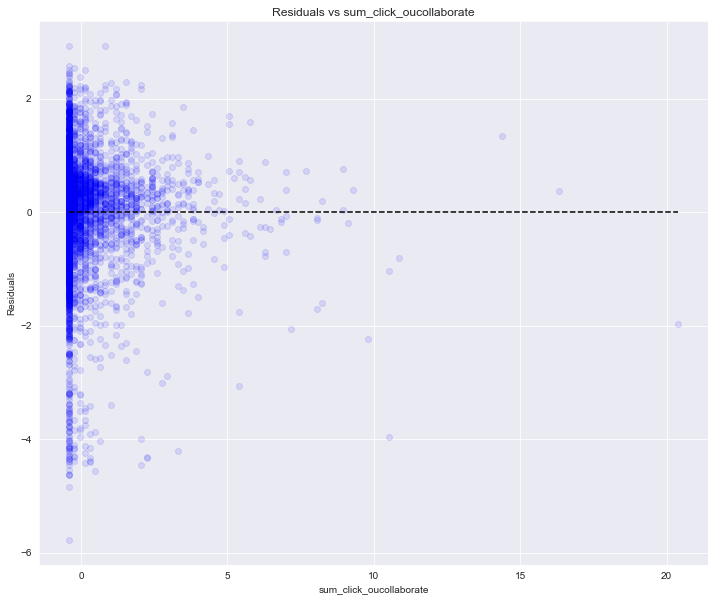

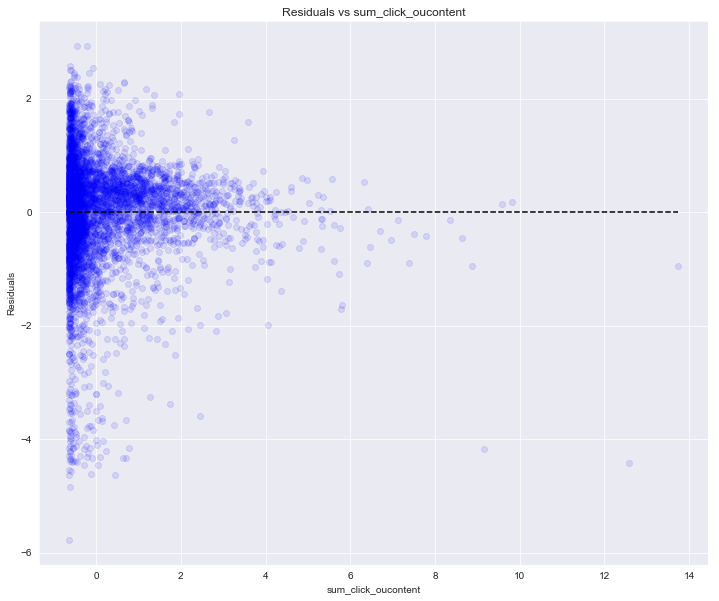

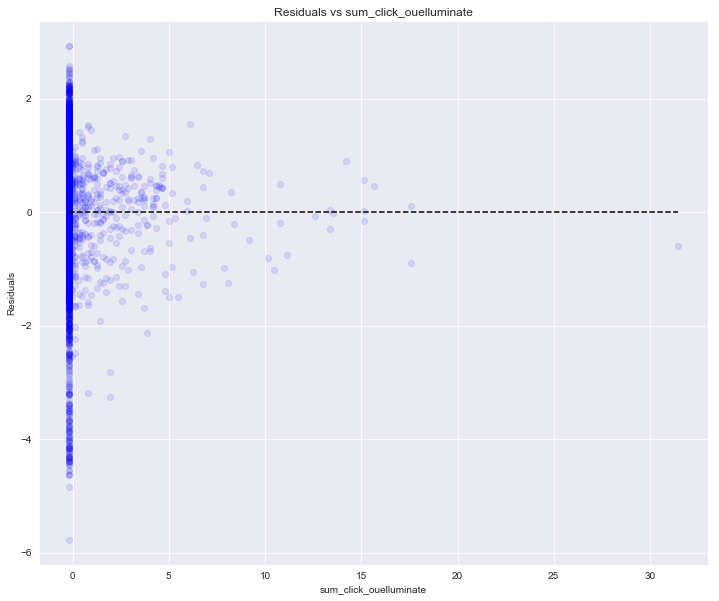

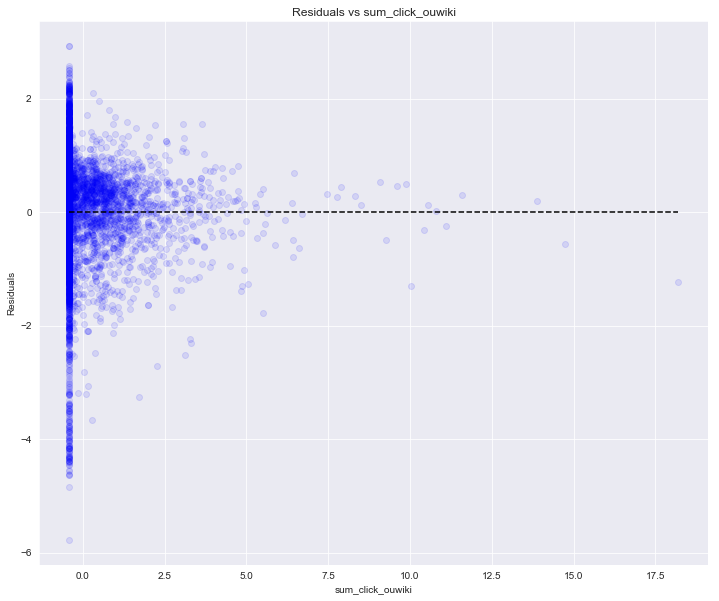

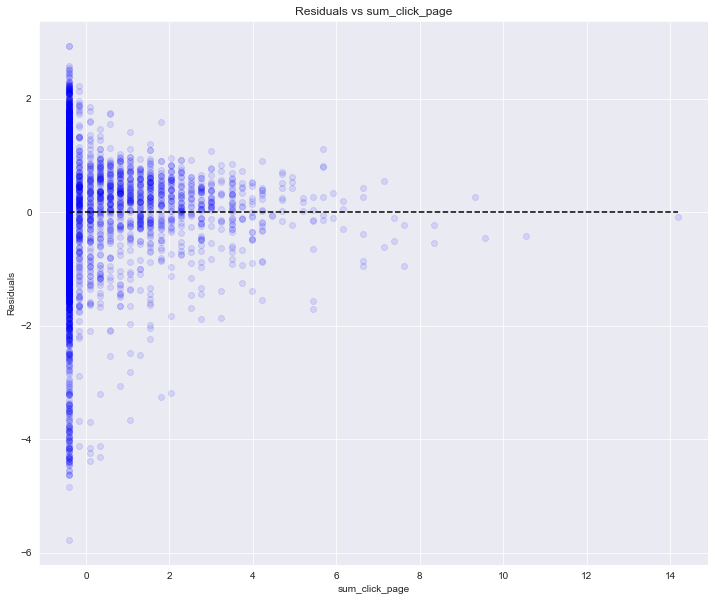

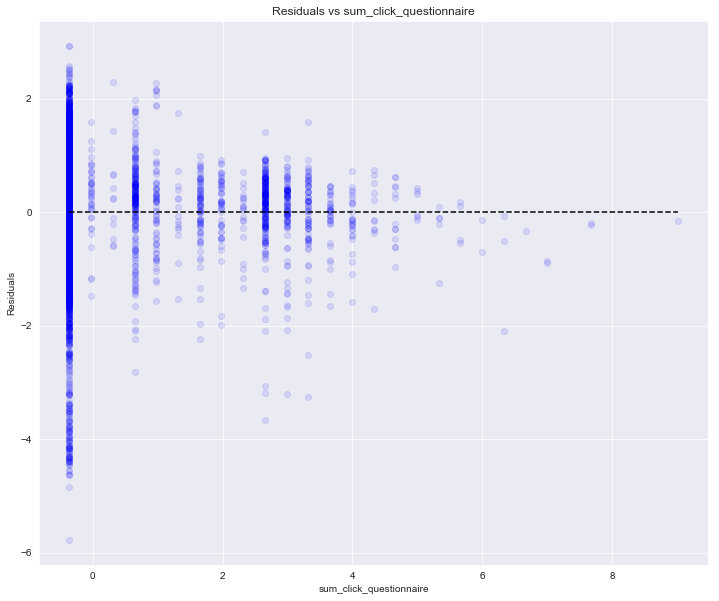

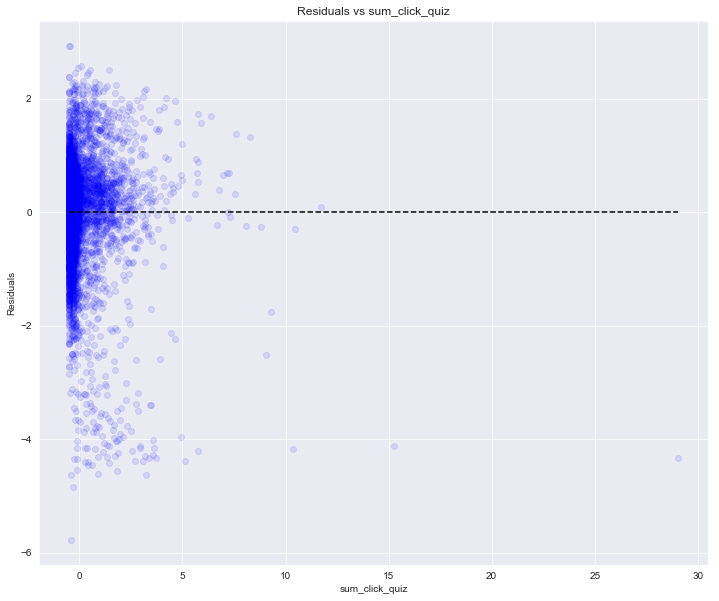

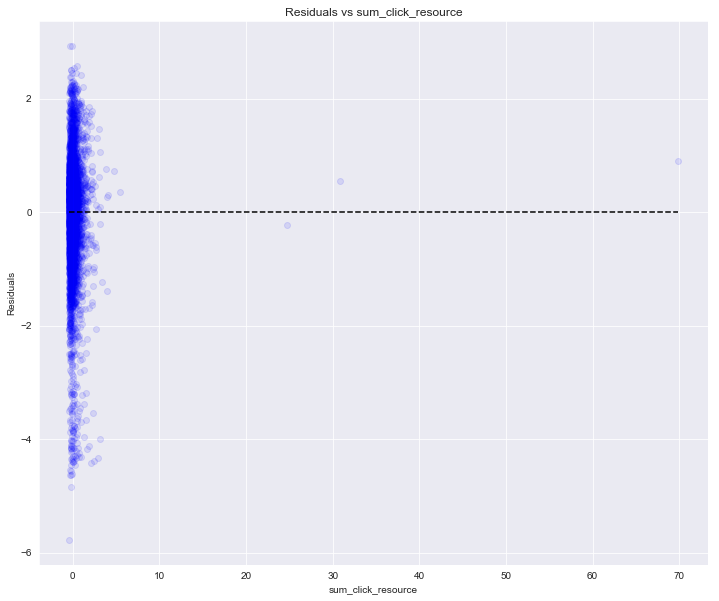

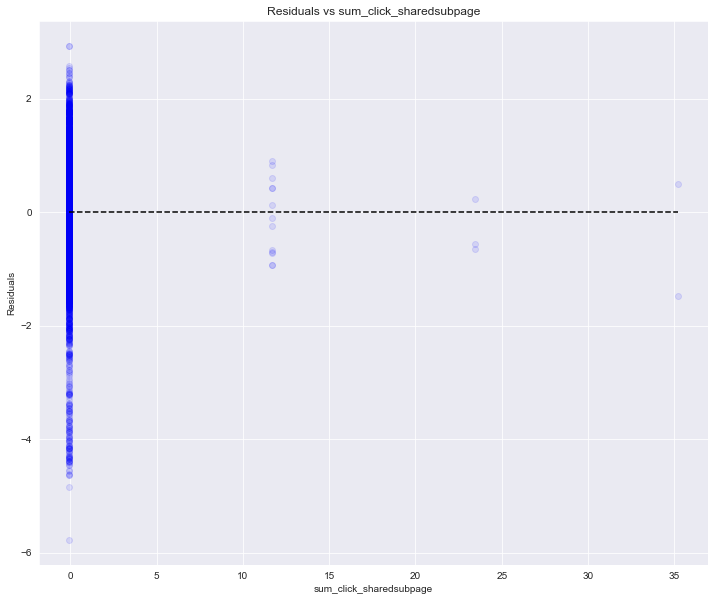

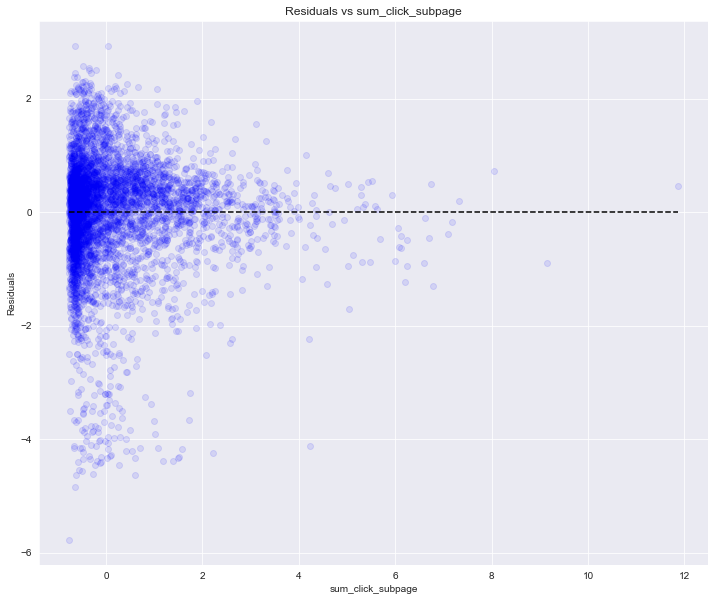

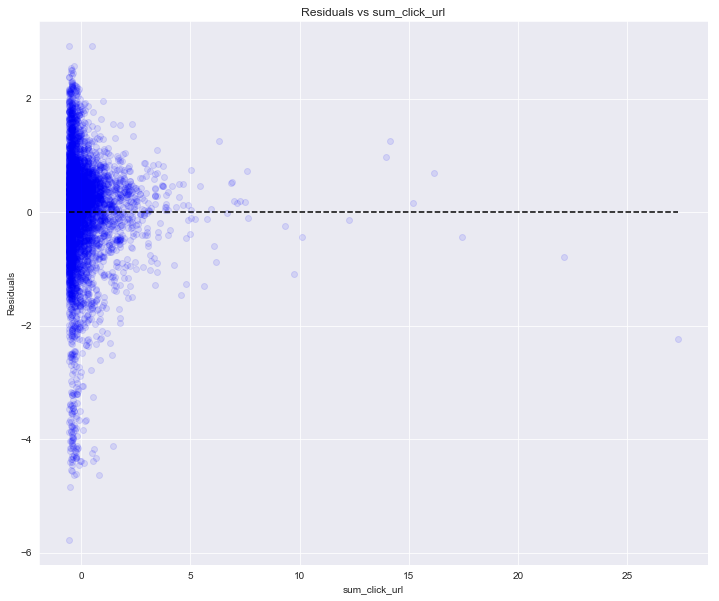

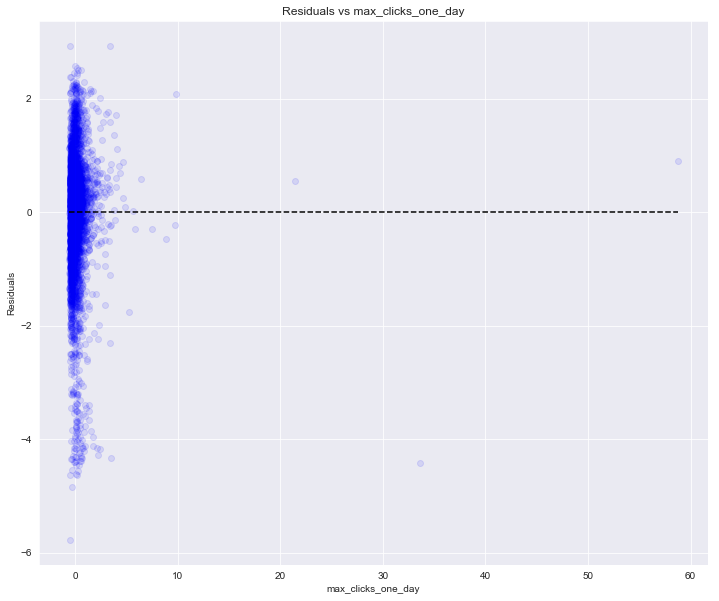

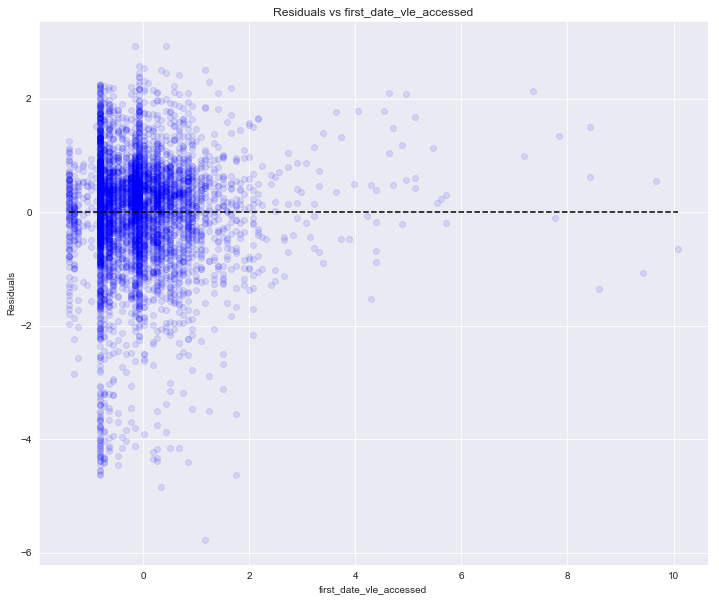

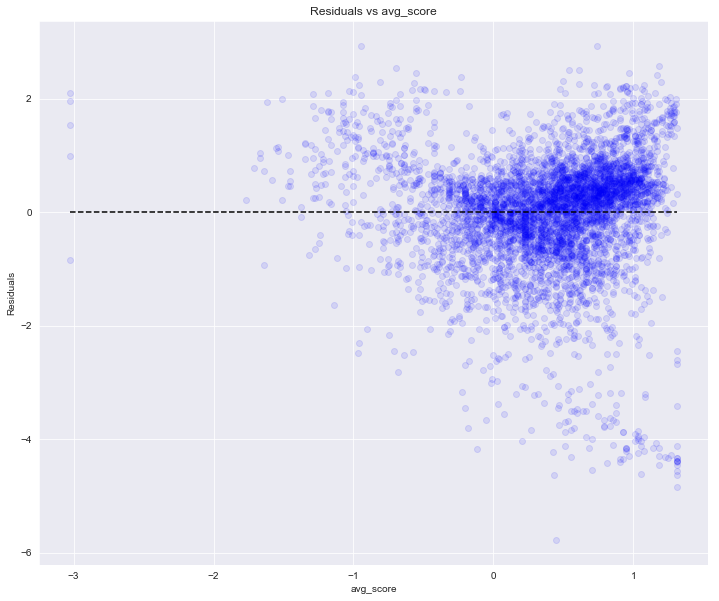

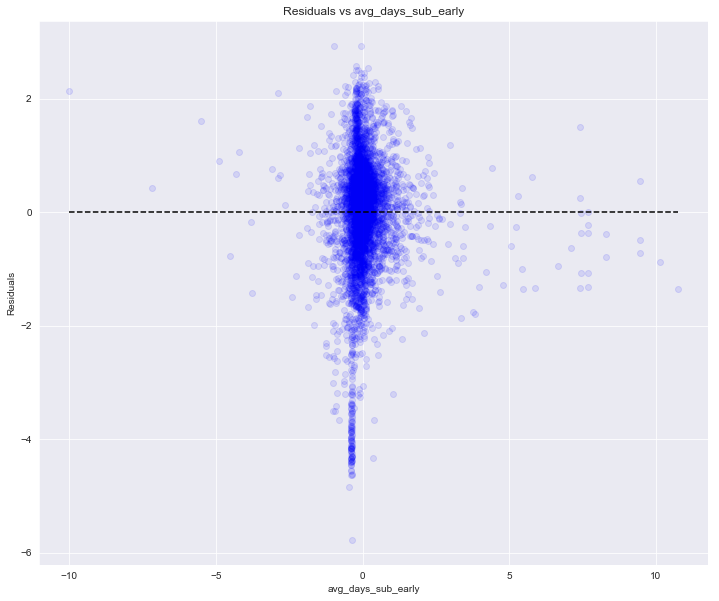

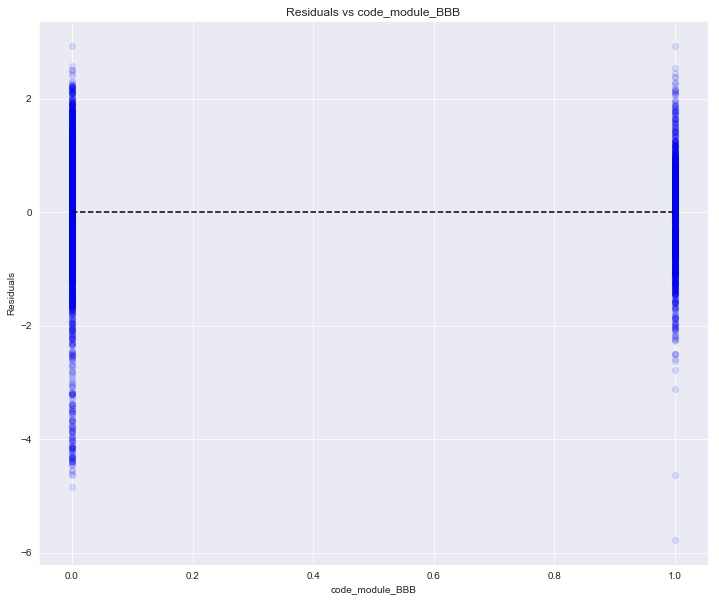

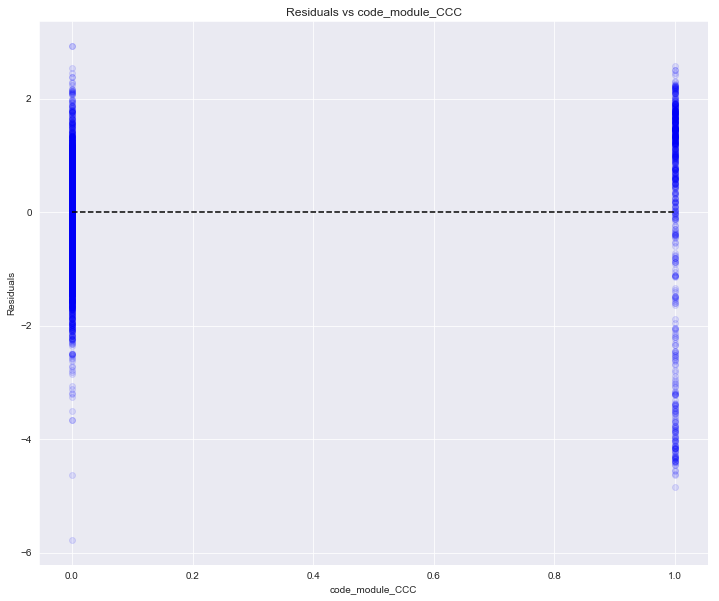

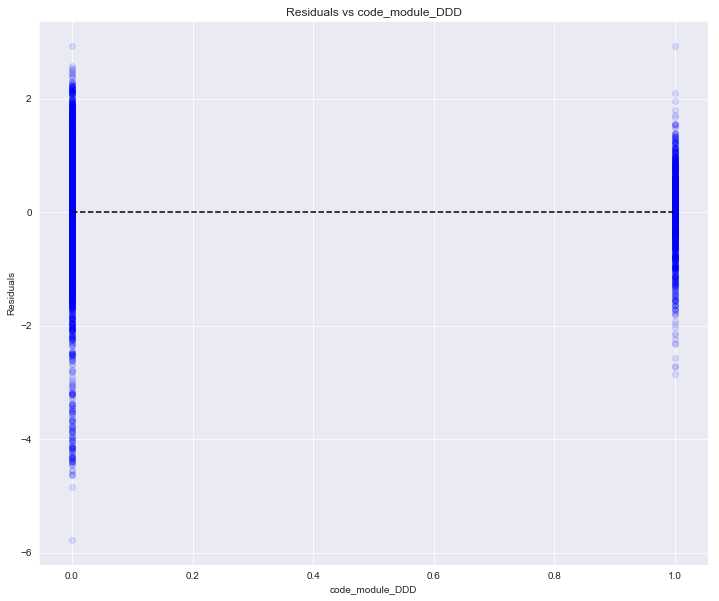

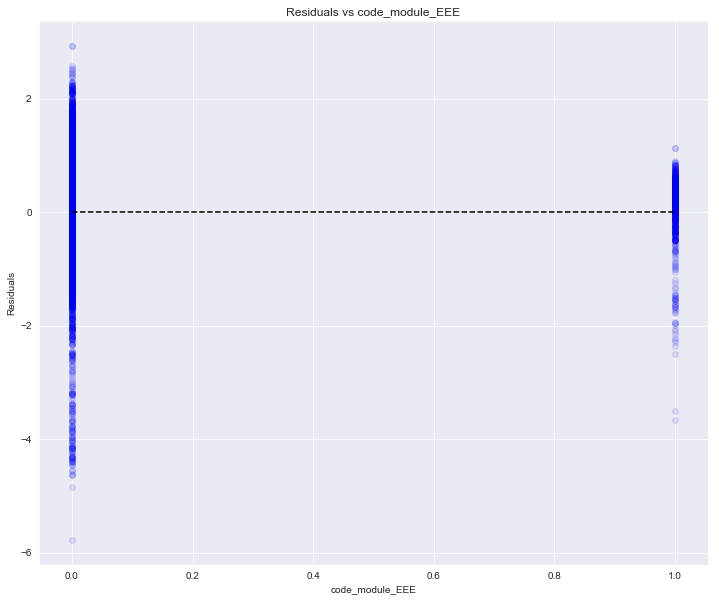

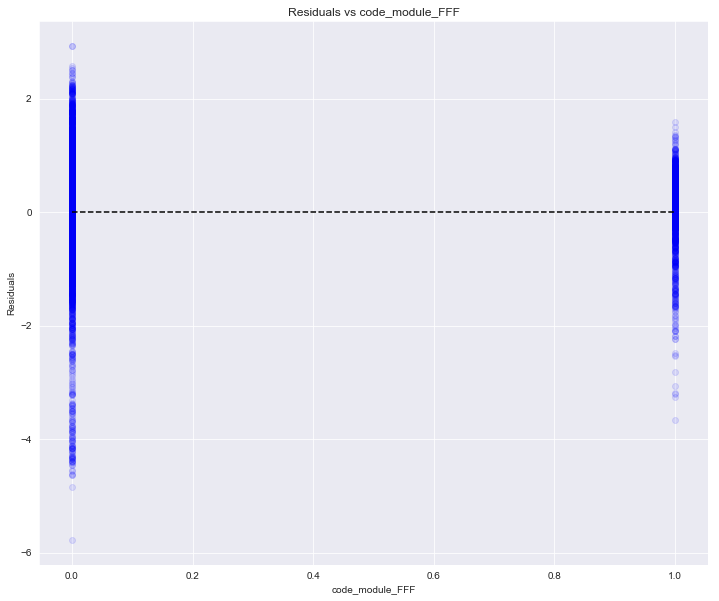

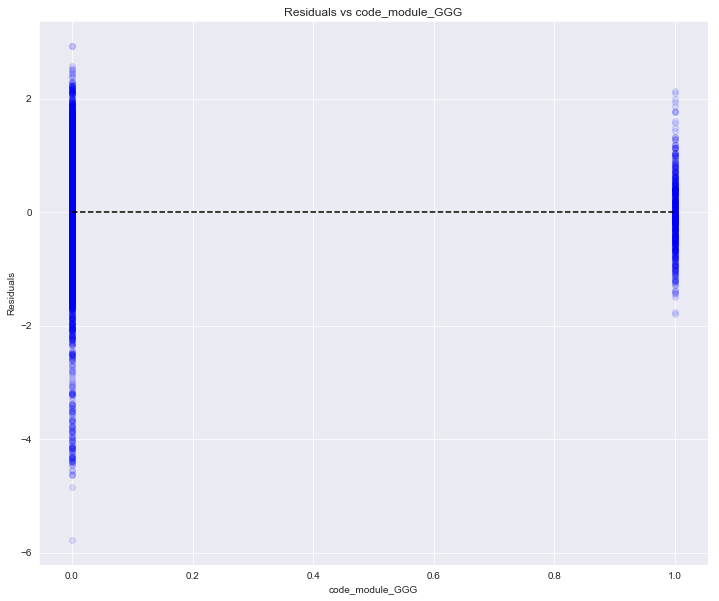

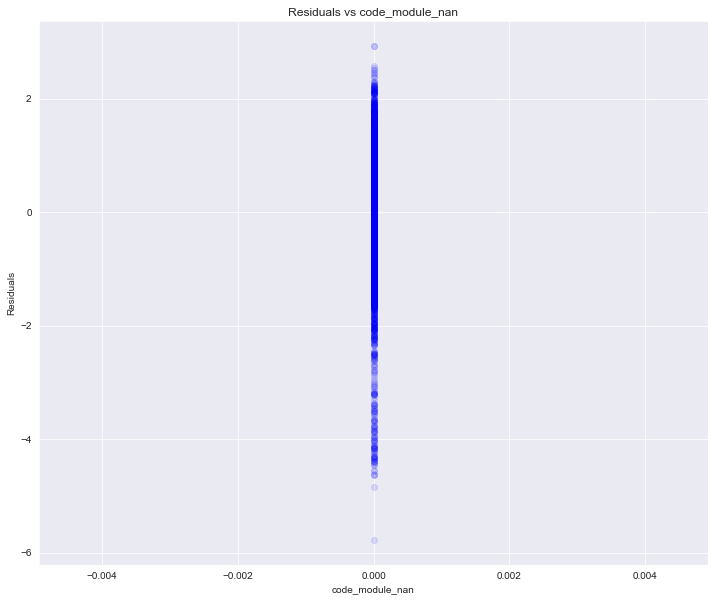

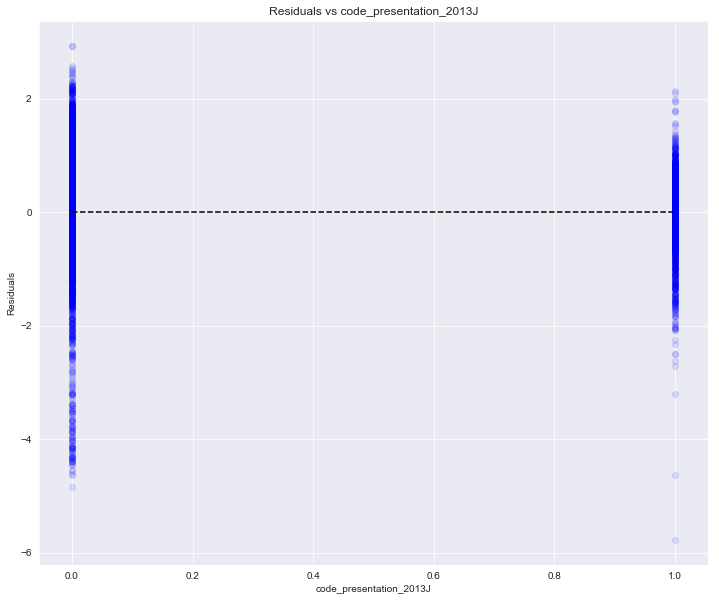

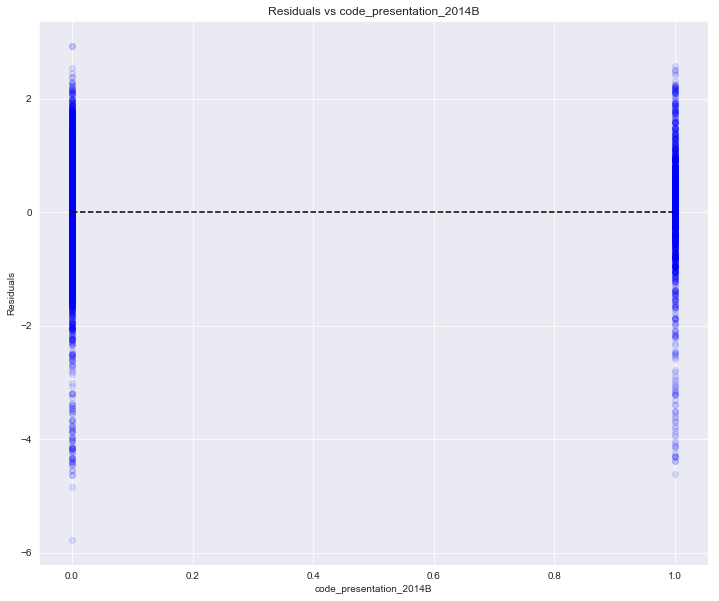

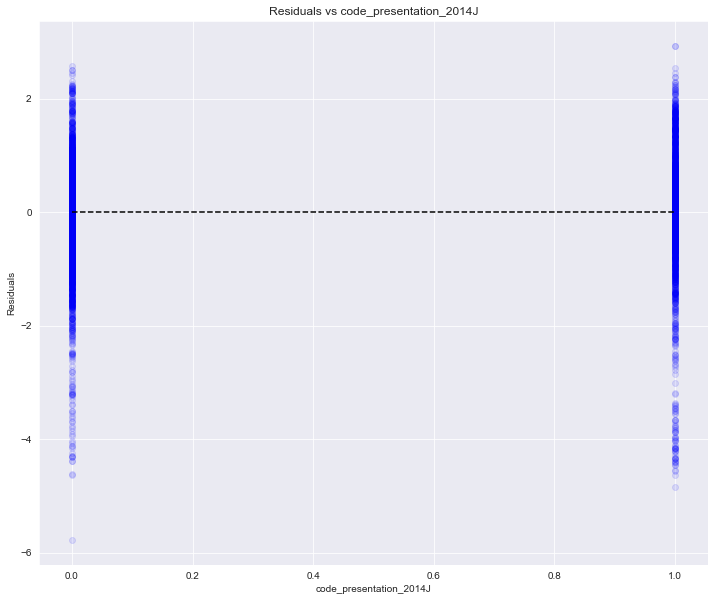

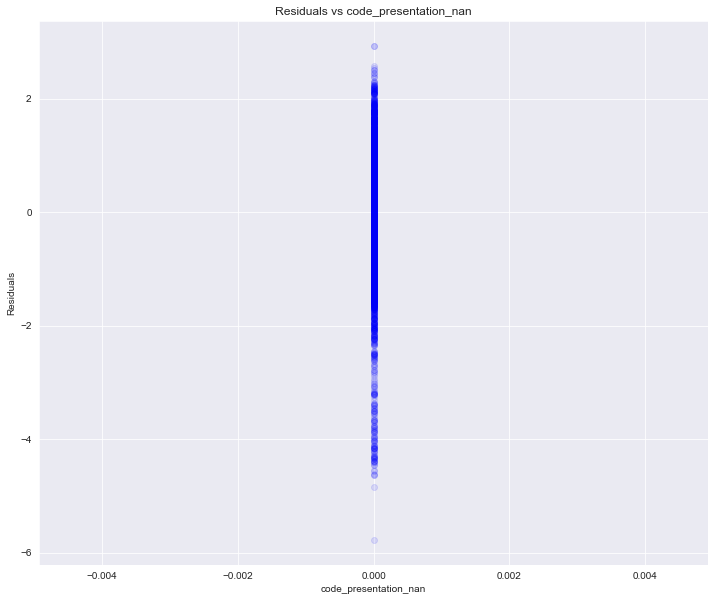

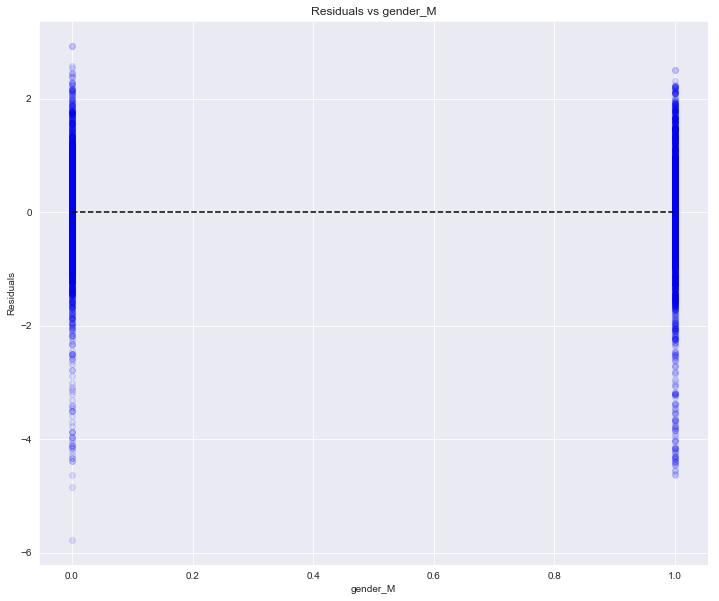

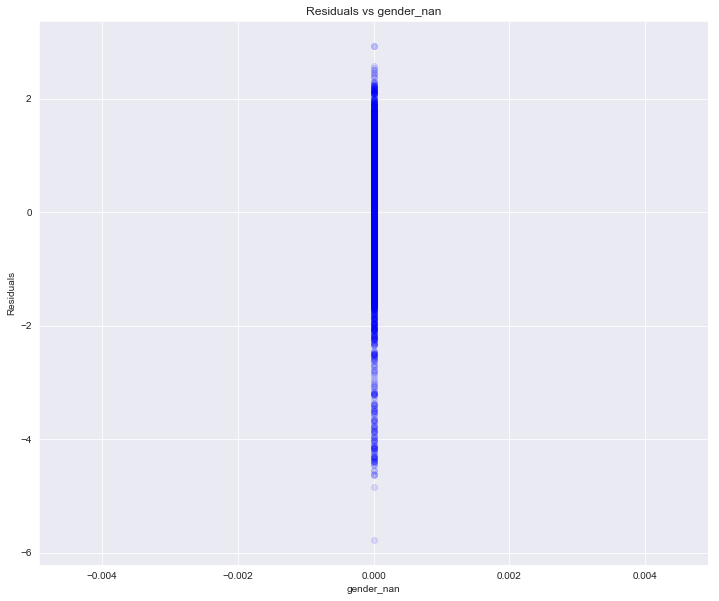

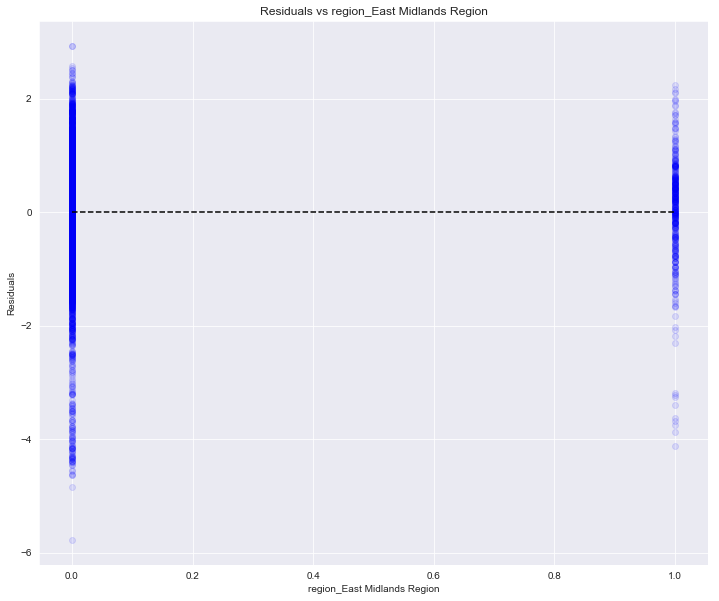

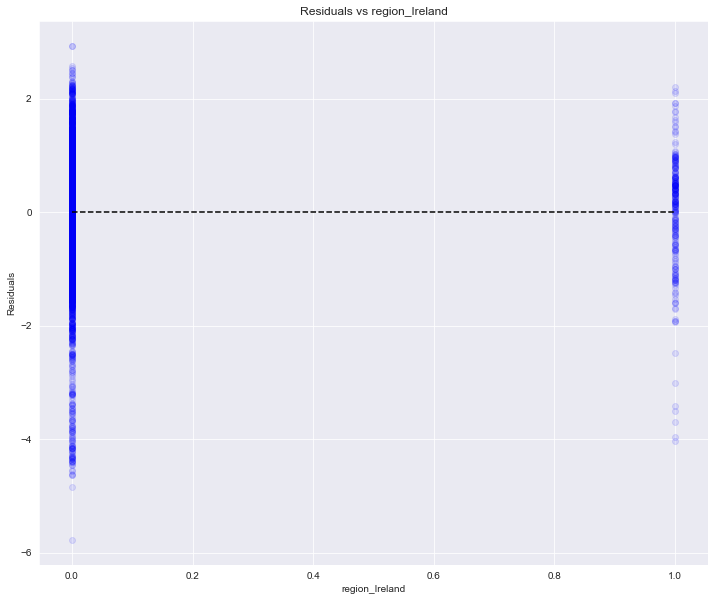

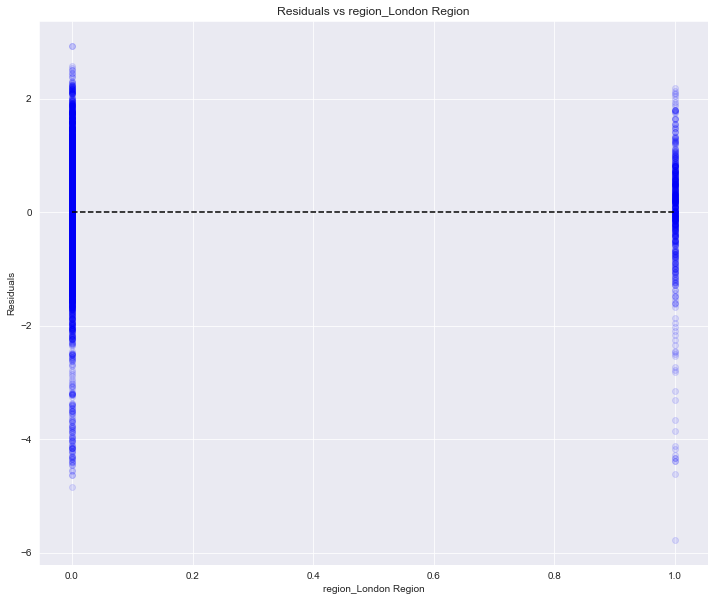

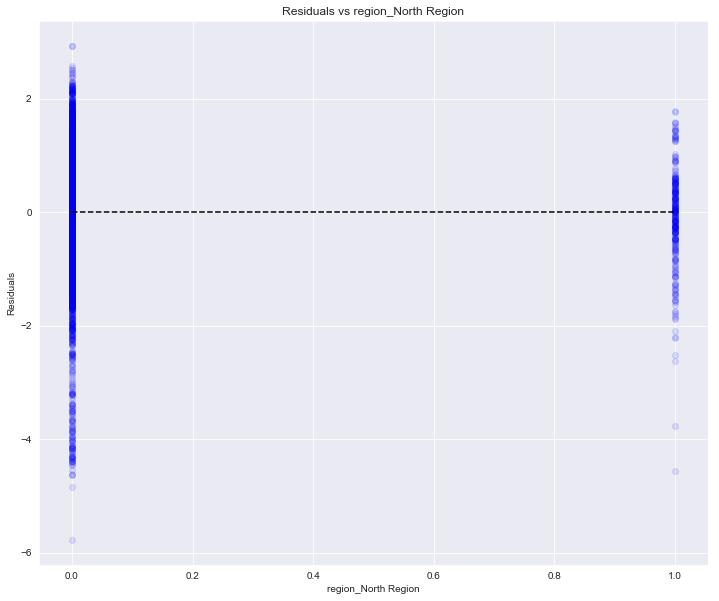

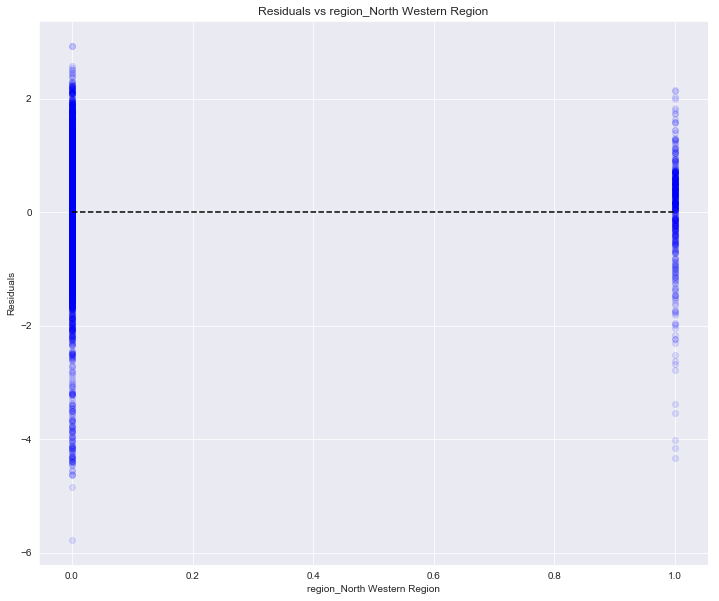

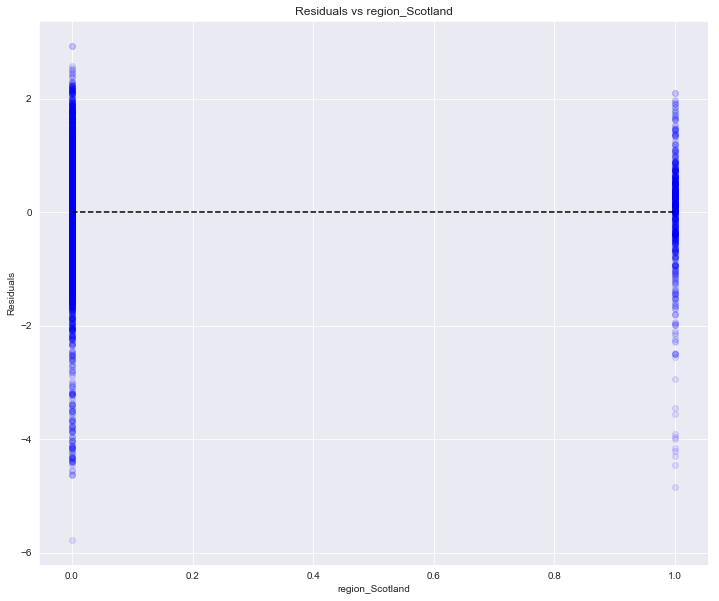

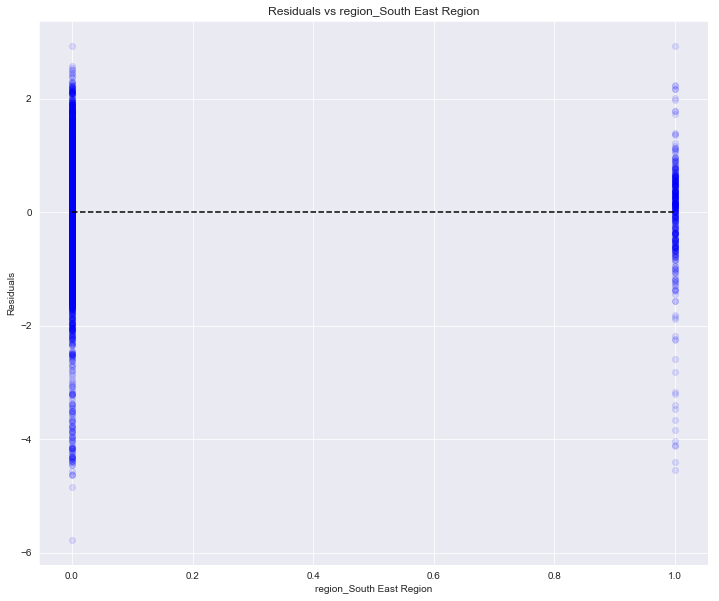

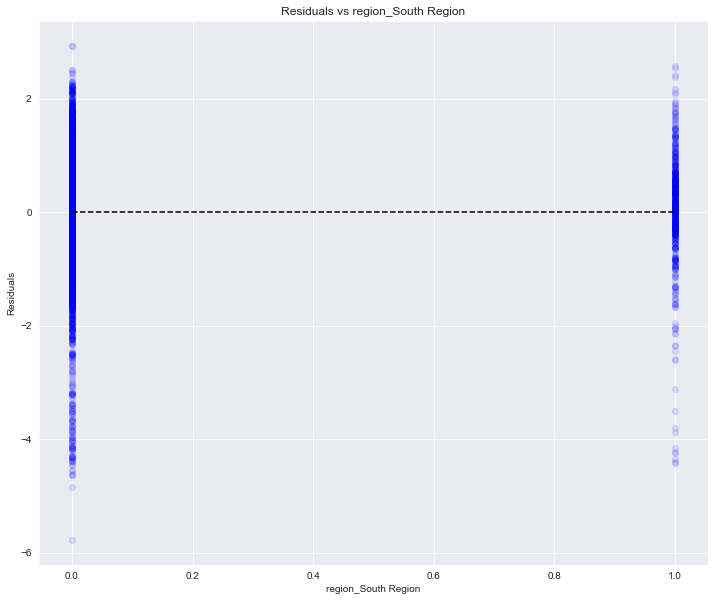

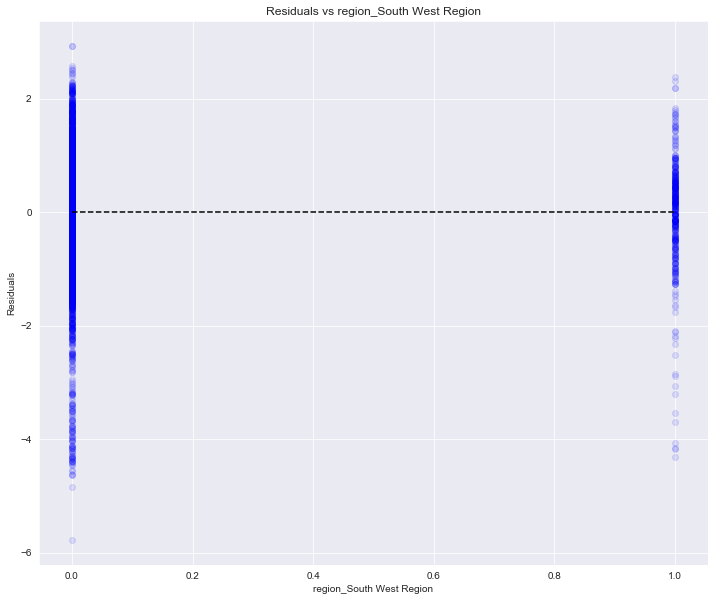

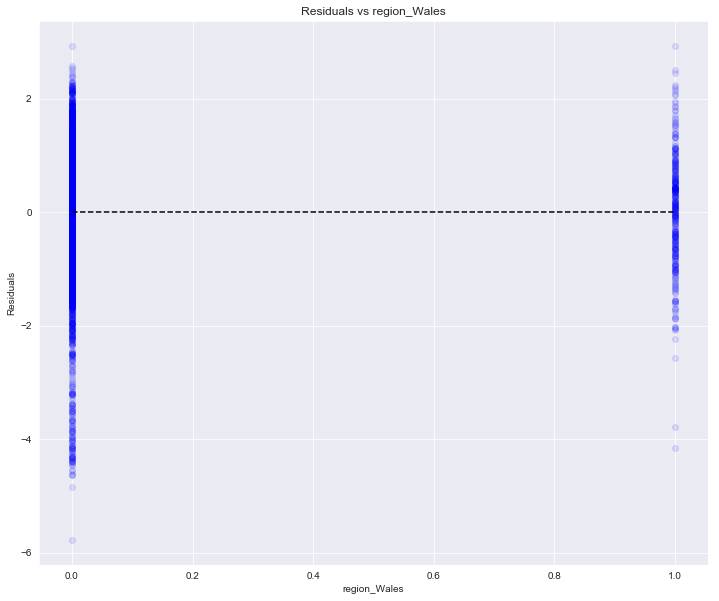

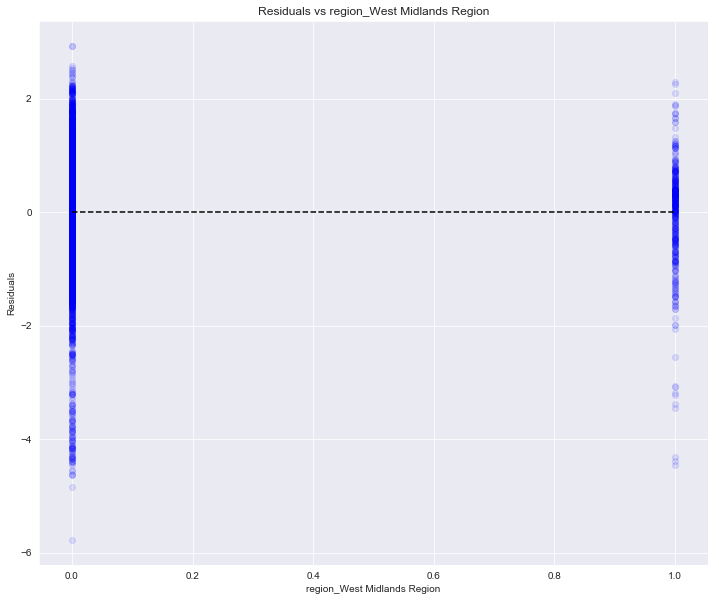

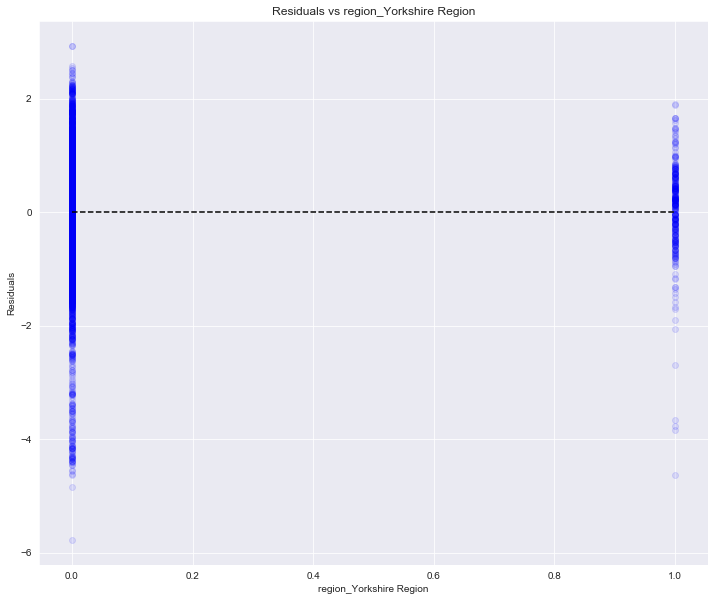

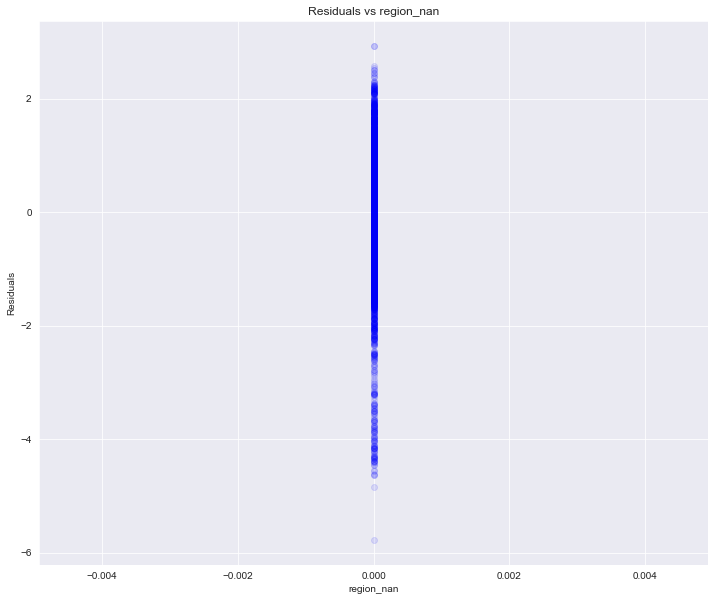

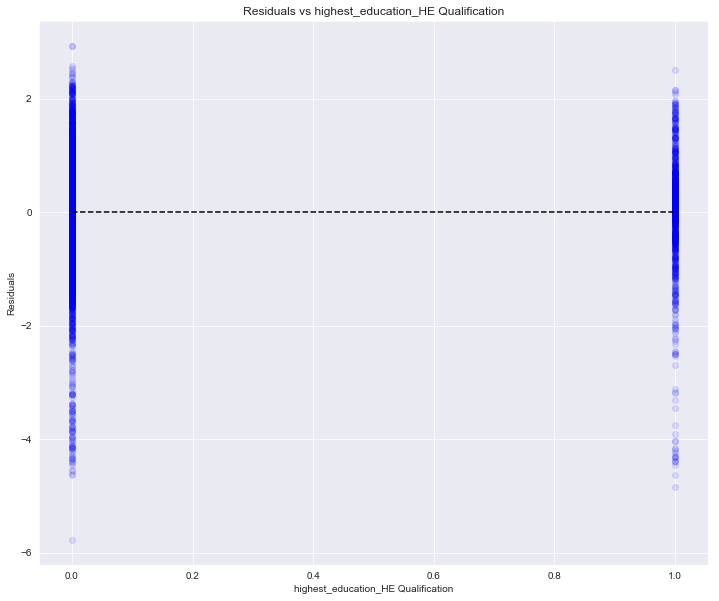

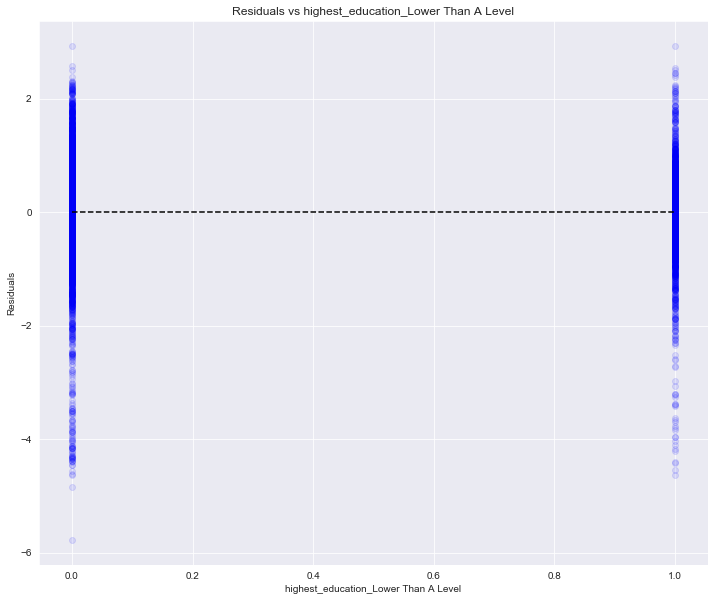

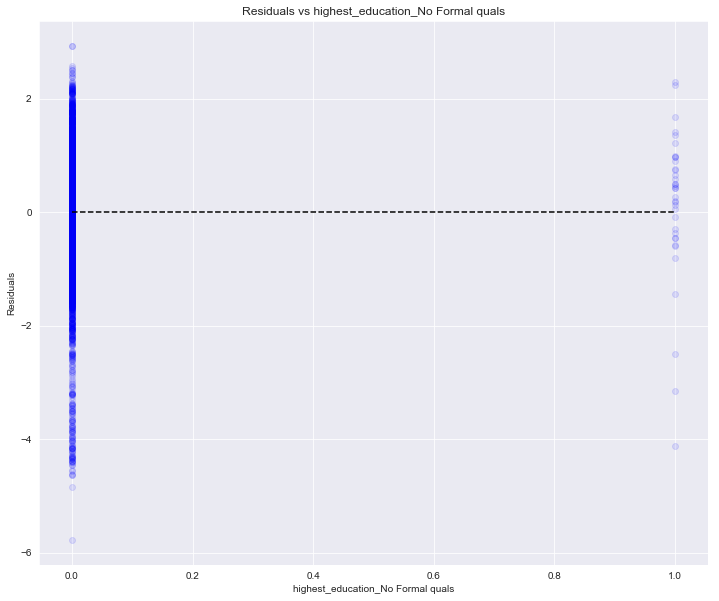

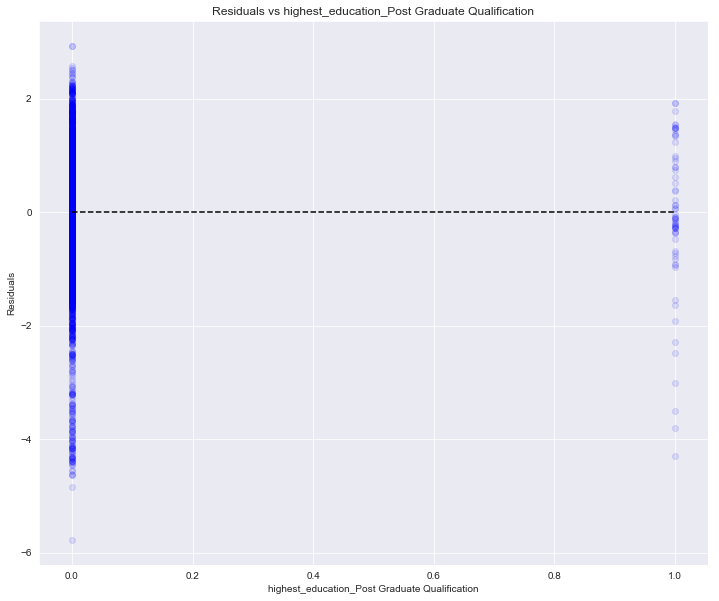

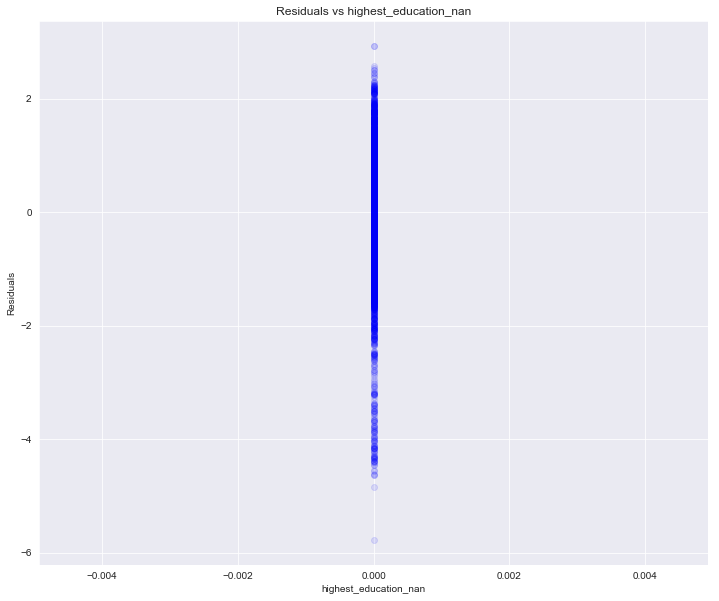

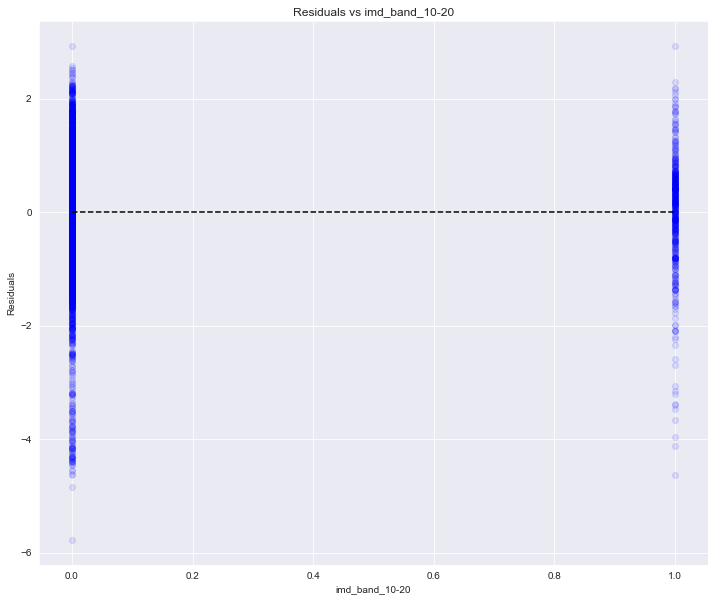

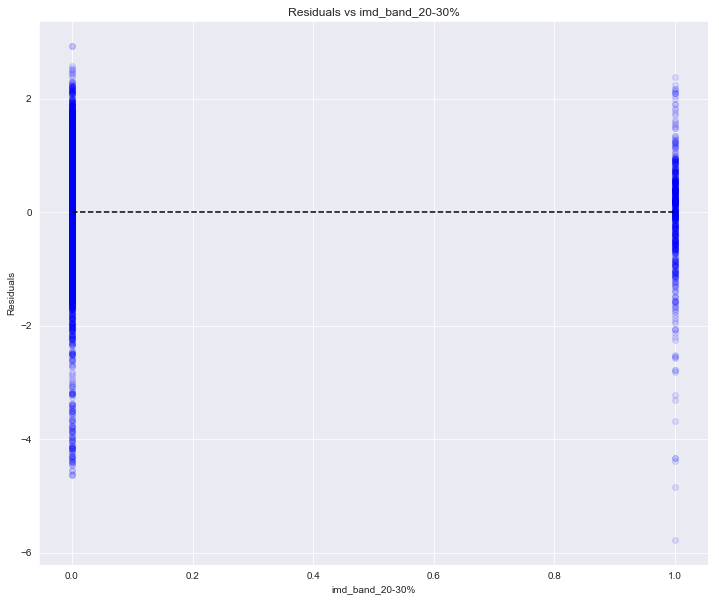

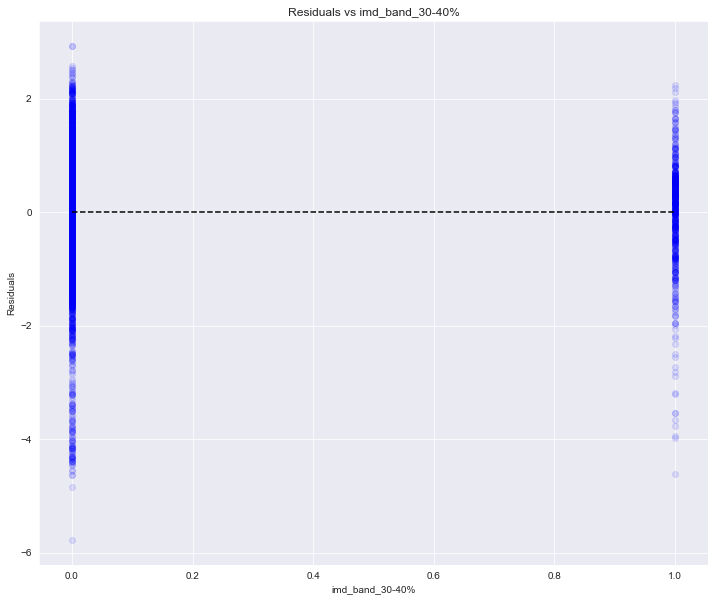

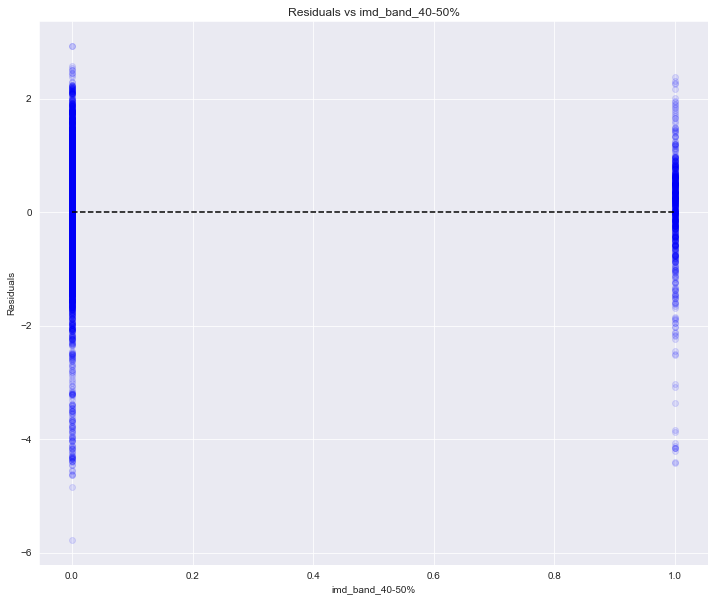

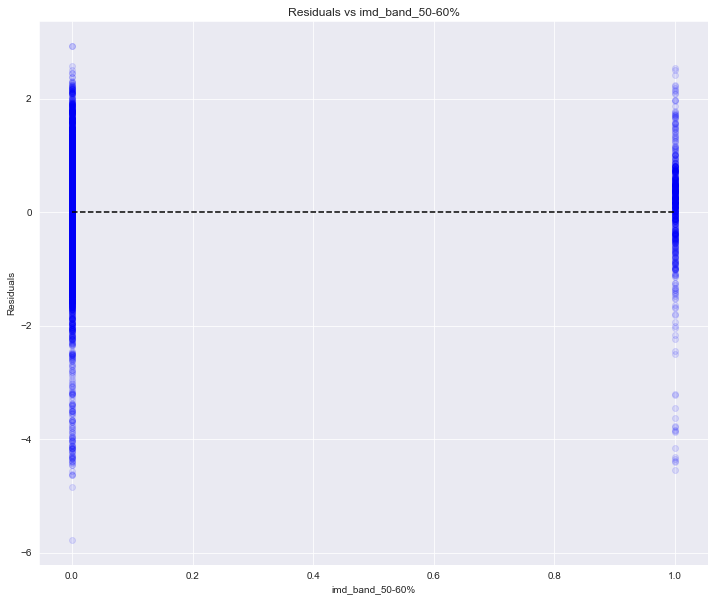

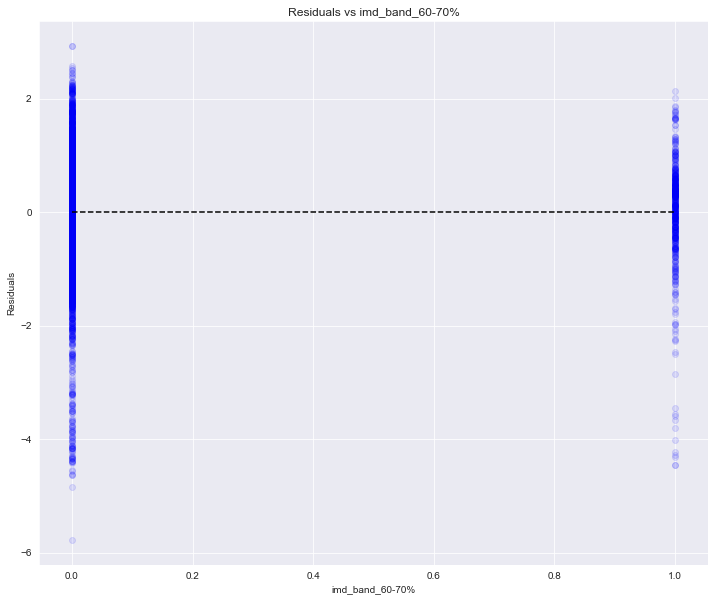

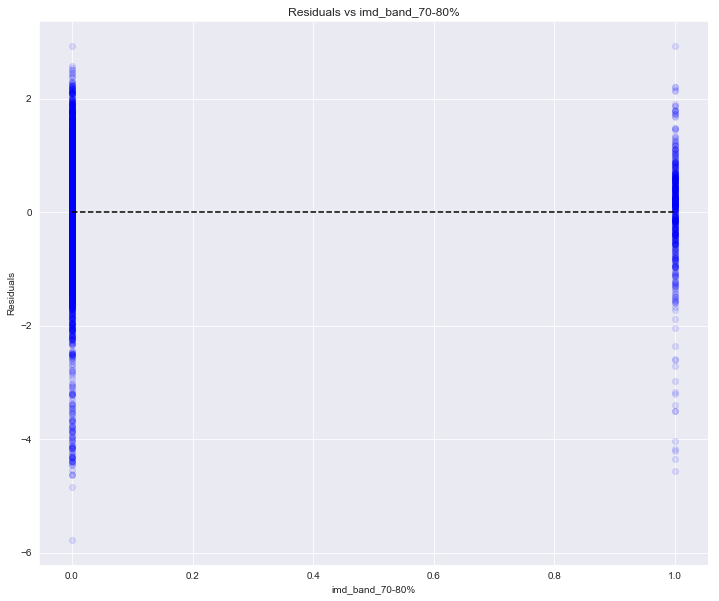

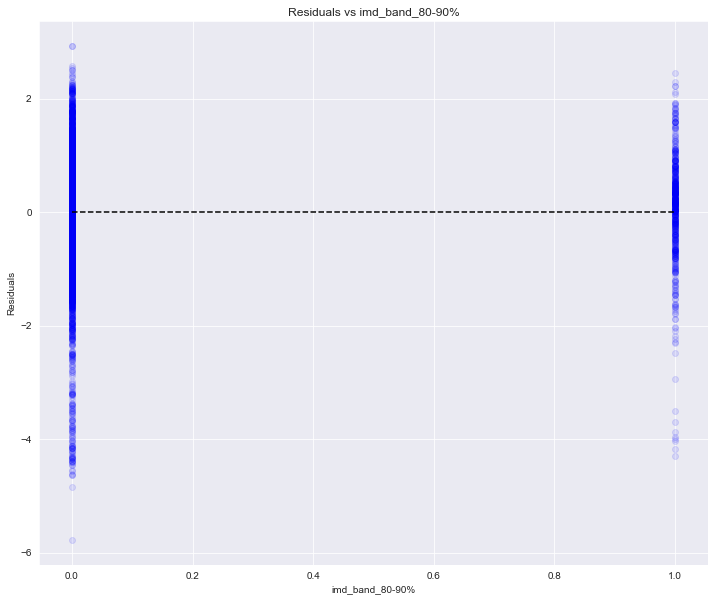

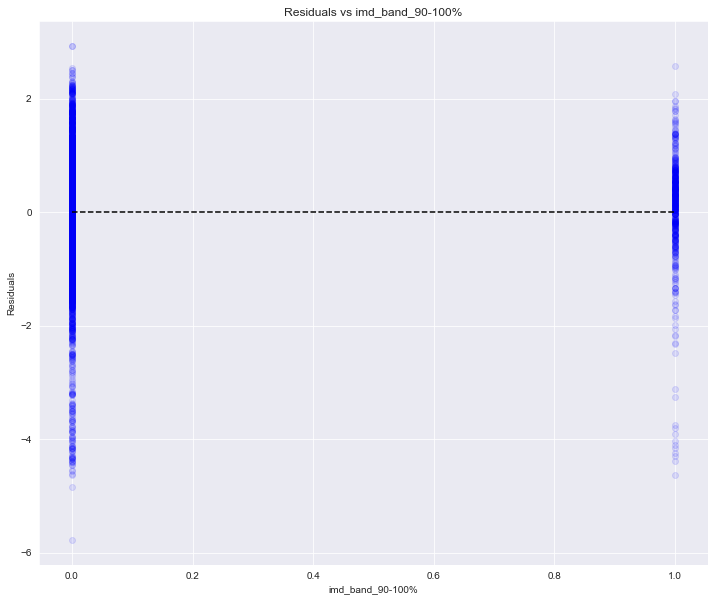

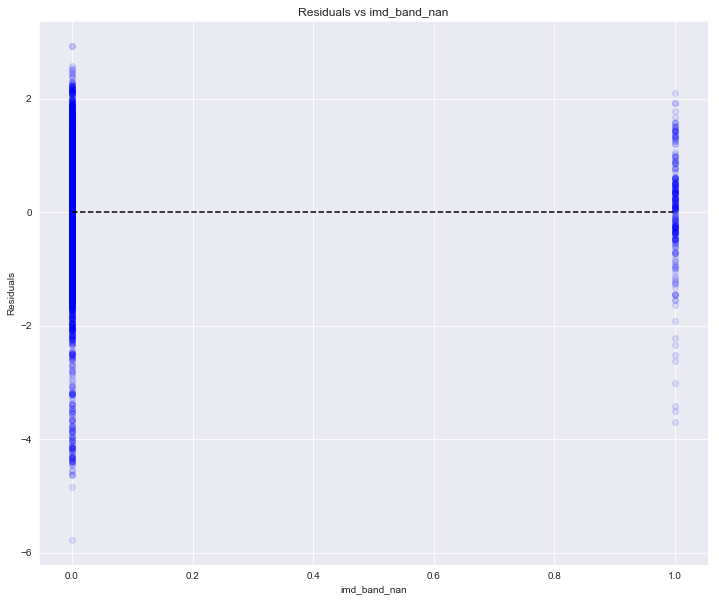

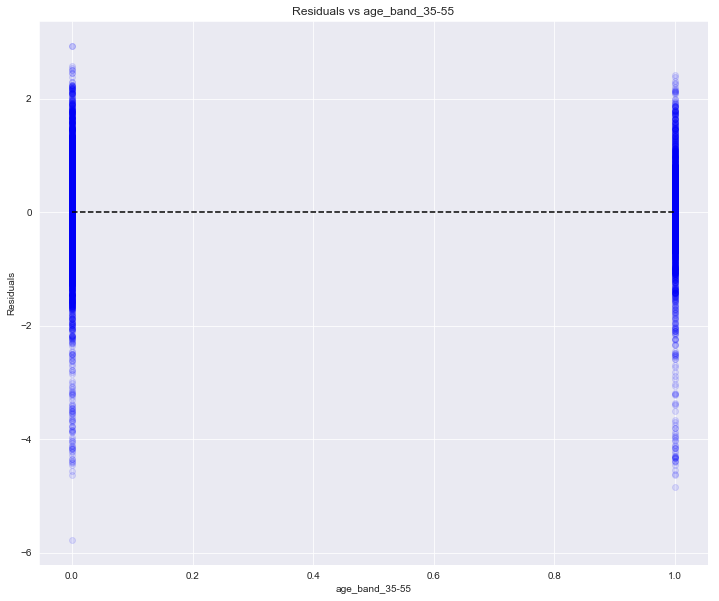

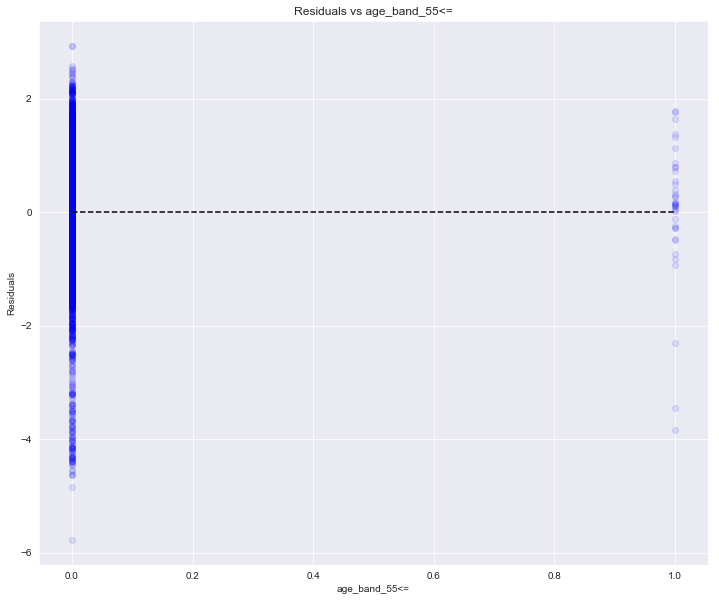

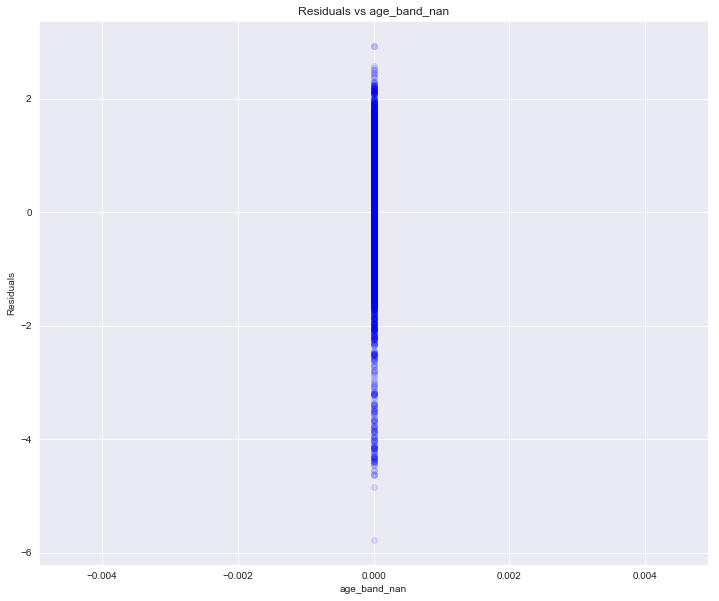

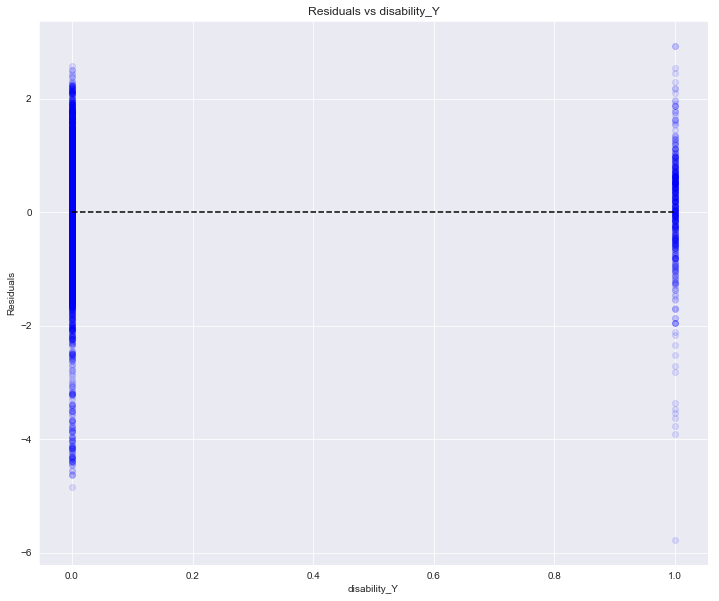

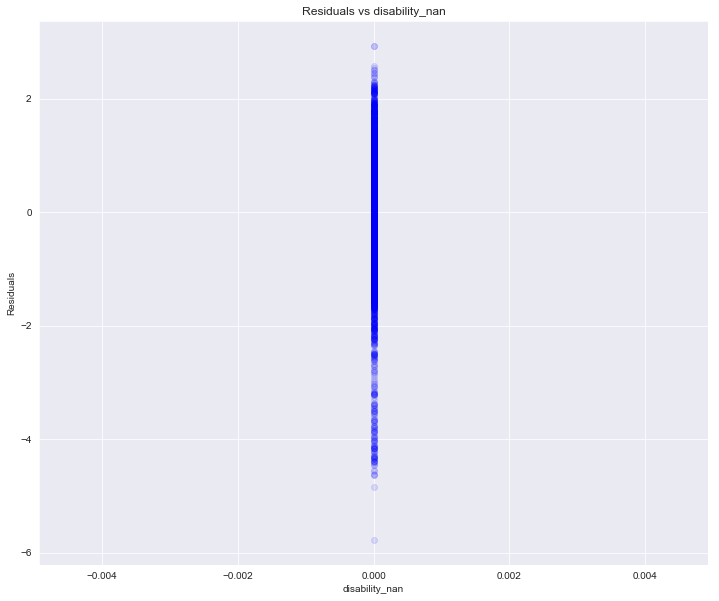

In [25]:
    predictions = lin_reg_model.predict(X_test)
    residuals = y_test - predictions
    Var_e = np.sum([(y_test - predictions)**2]) / (len(y_test) - 2)
    SE_regression = Var_e**0.5
    studentized_residuals = residuals / SE_regression
    plot_residuals(studentized_residuals, y_test, X_test.columns, X_test)

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


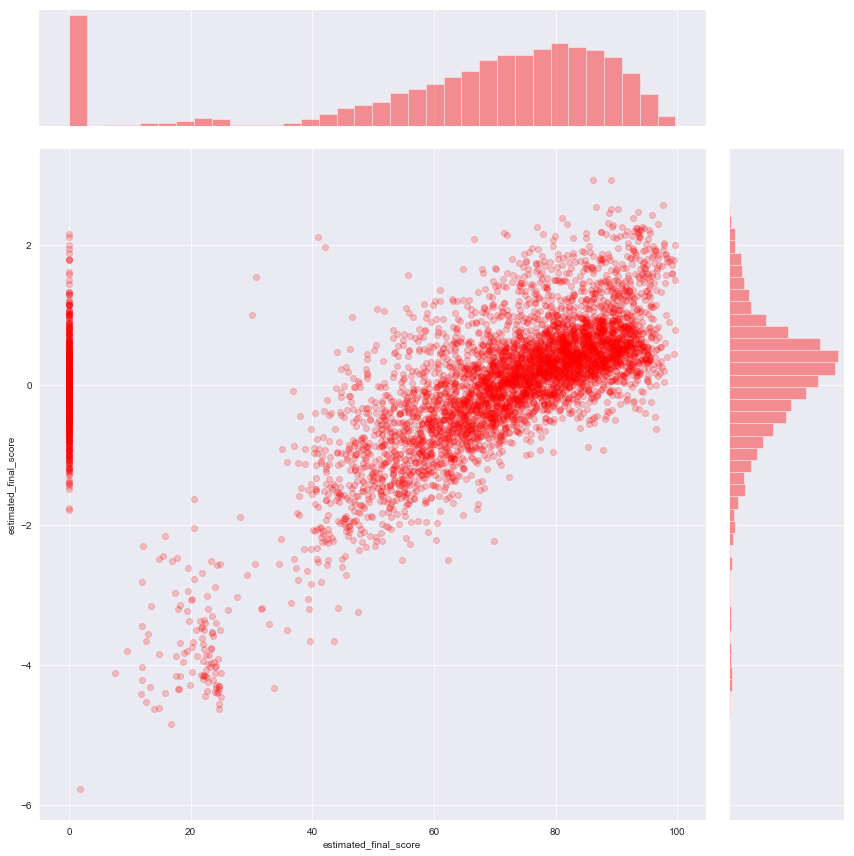

In [26]:
sns.jointplot(x=y_test, y=studentized_residuals, height=12, color='r', alpha=0.2)

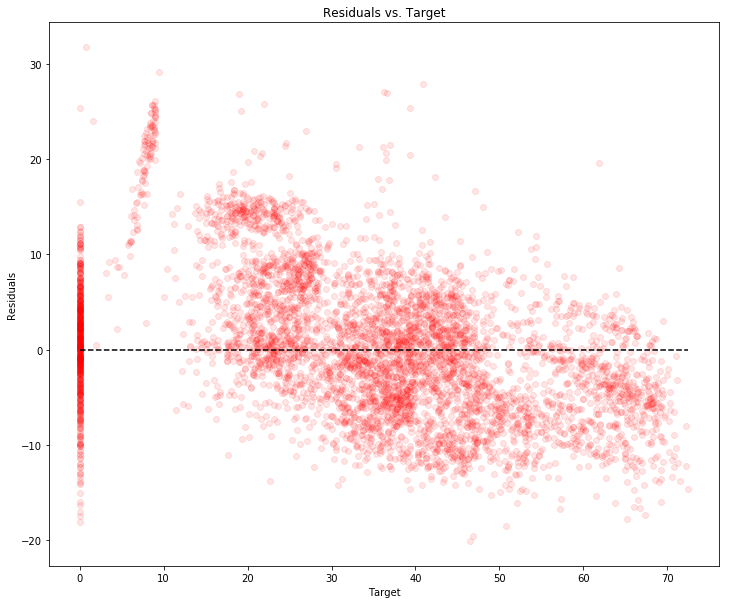

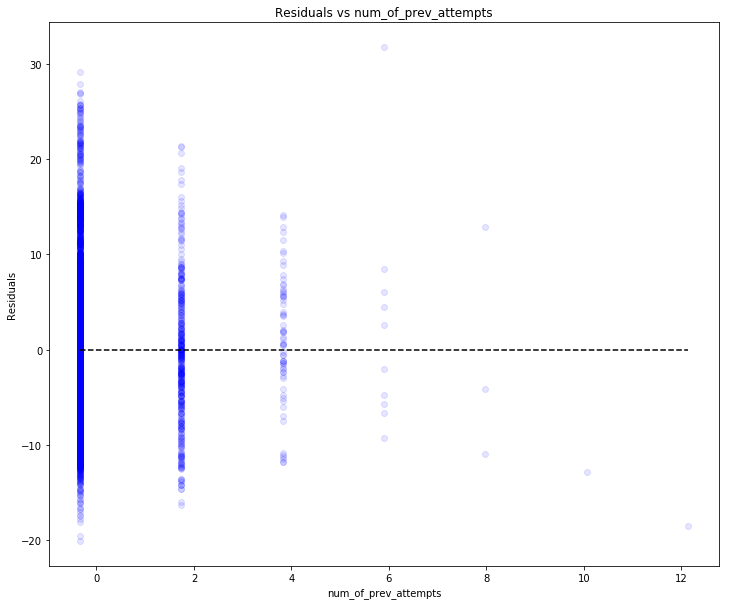

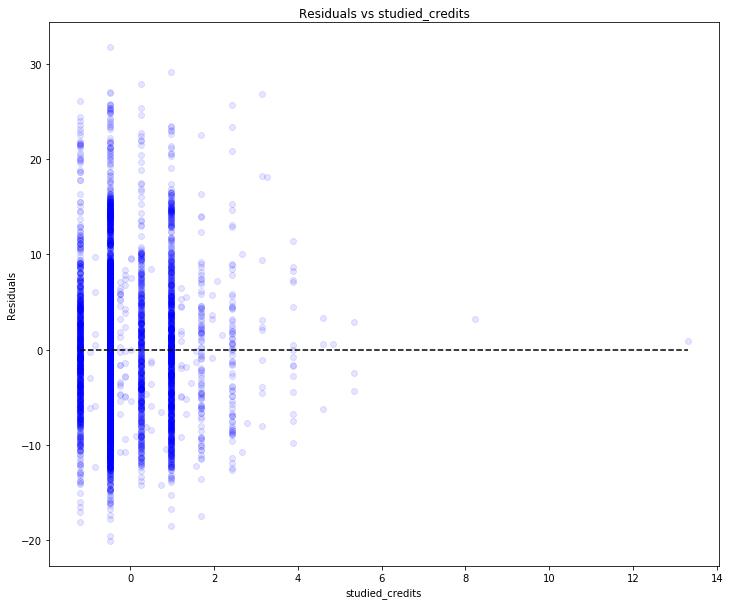

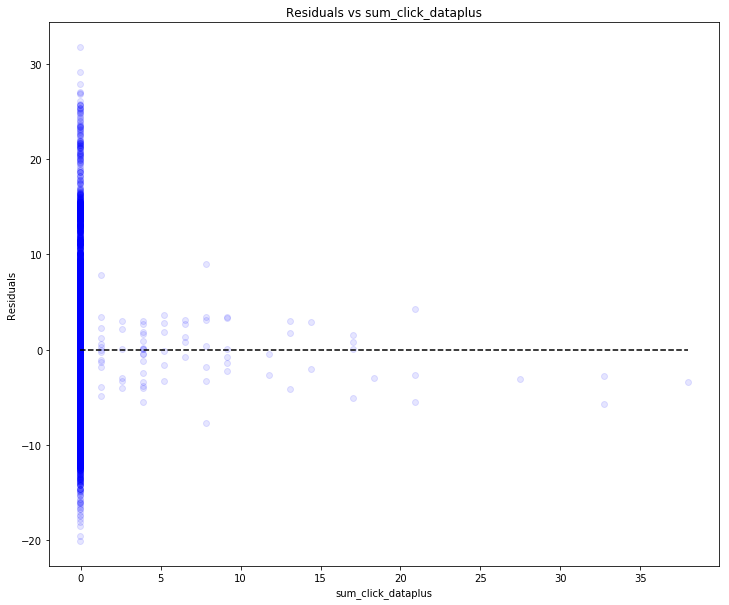

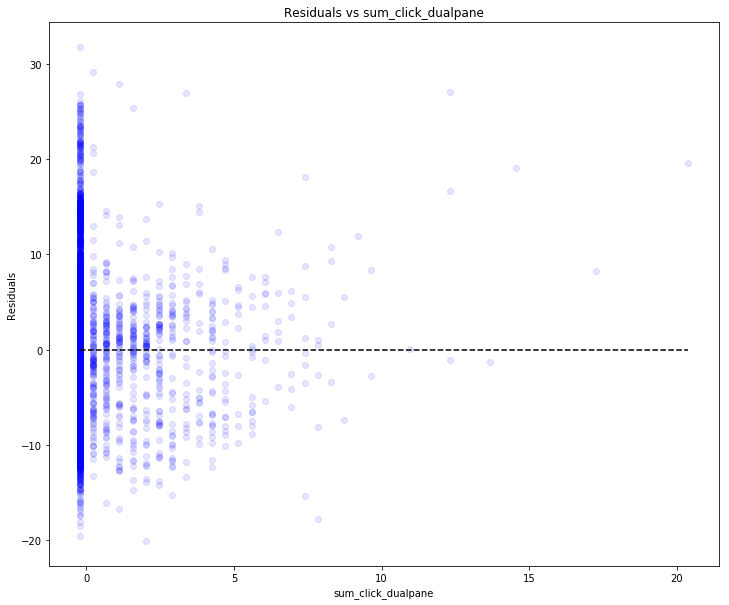

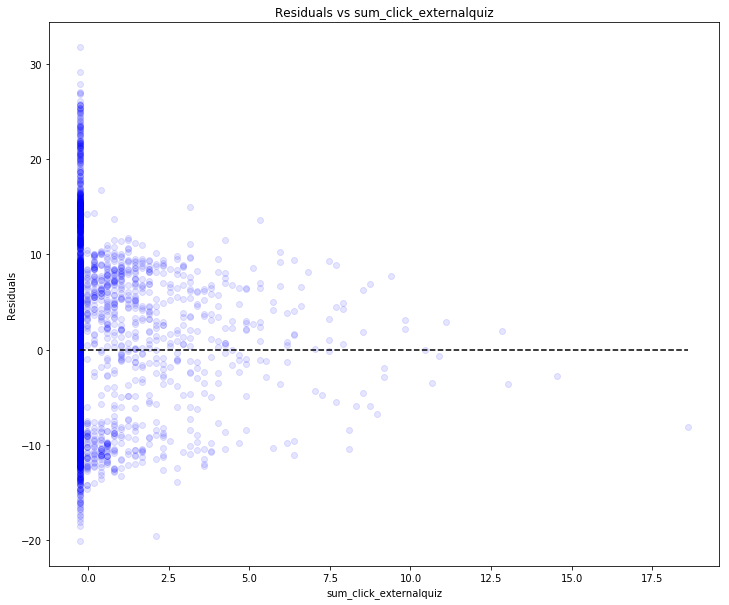

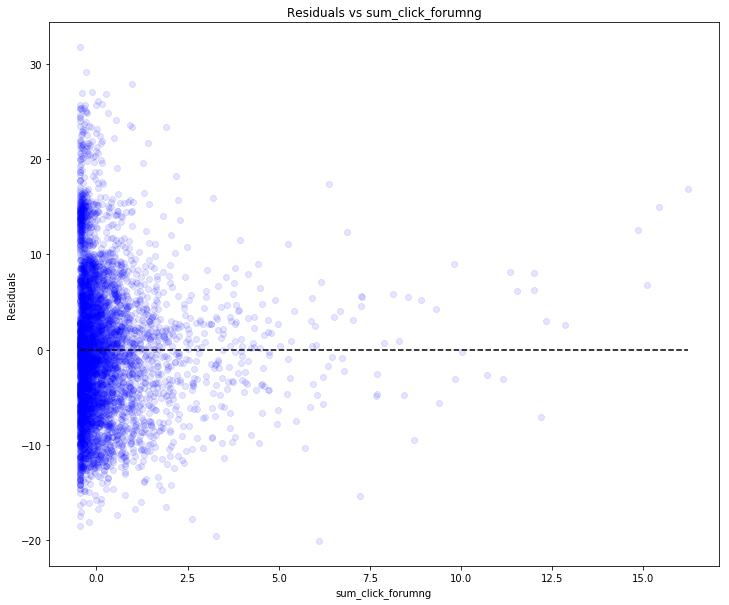

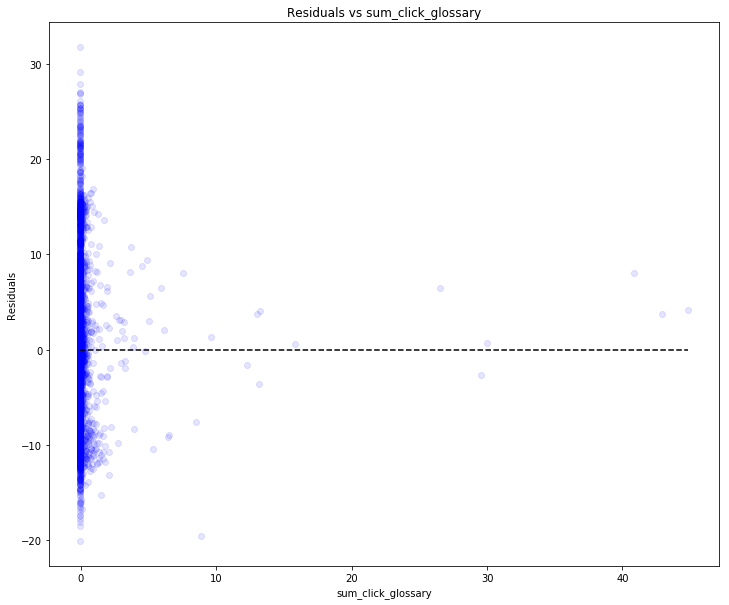

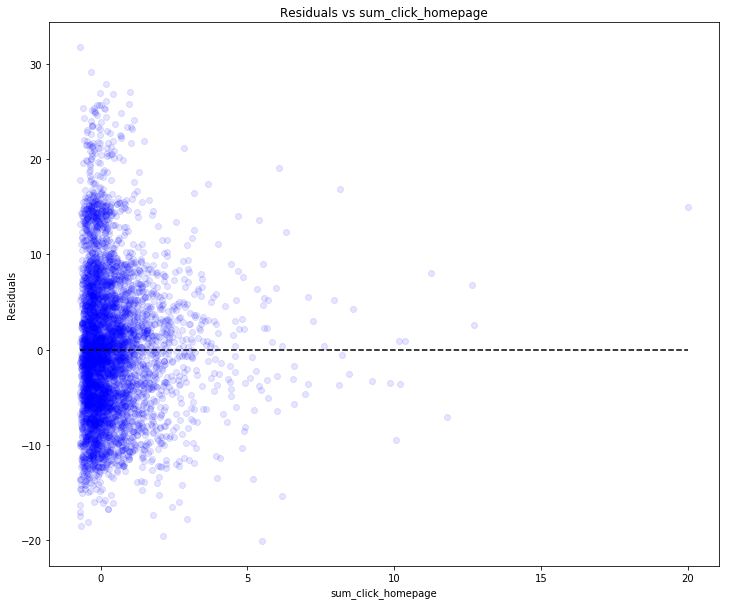

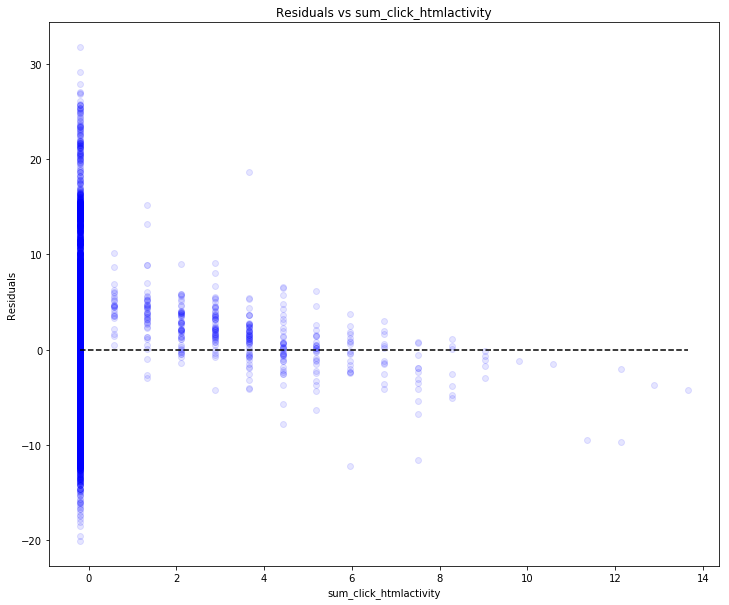

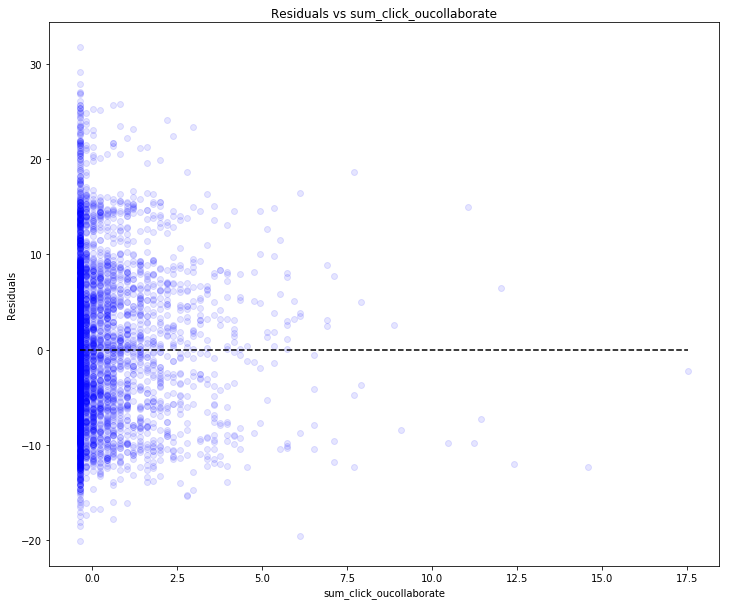

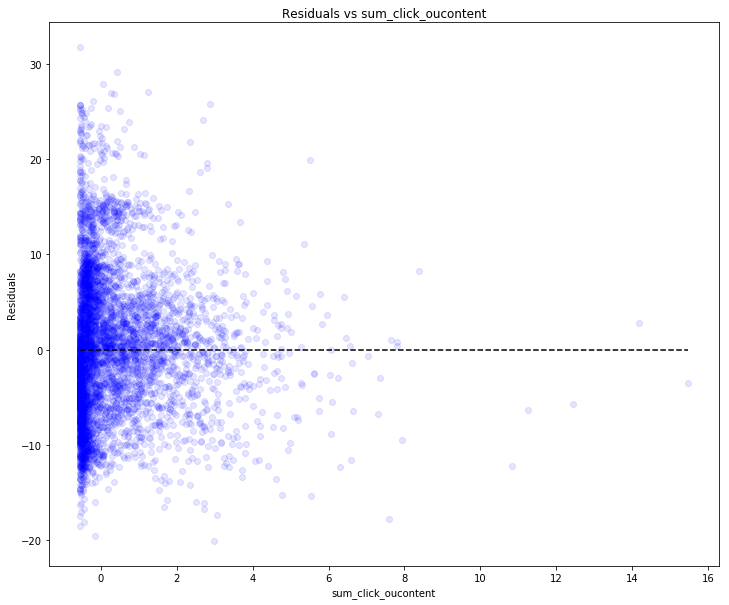

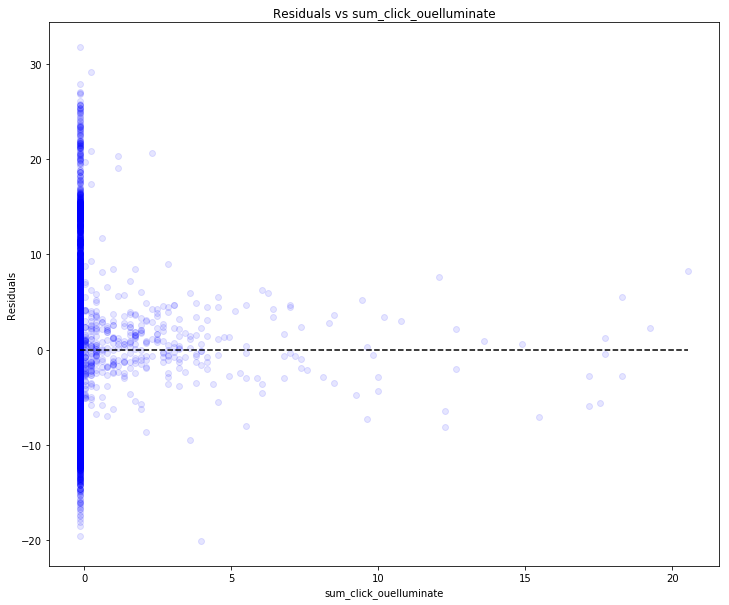

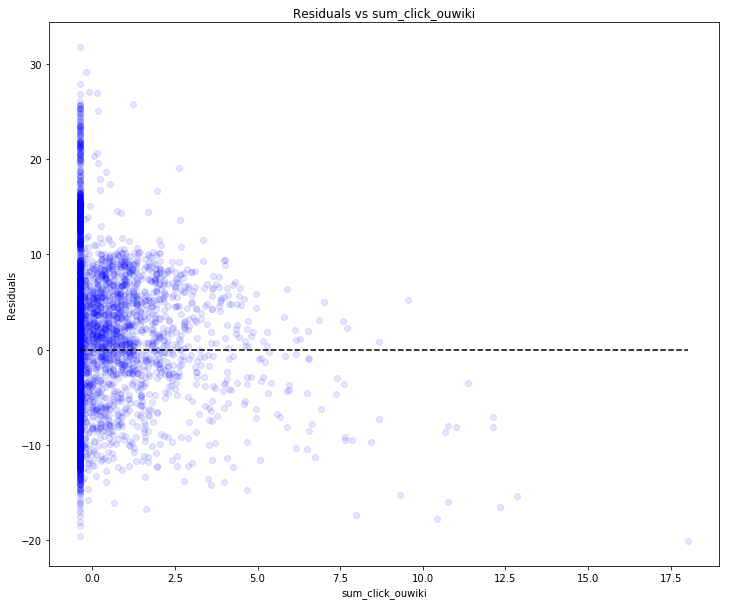

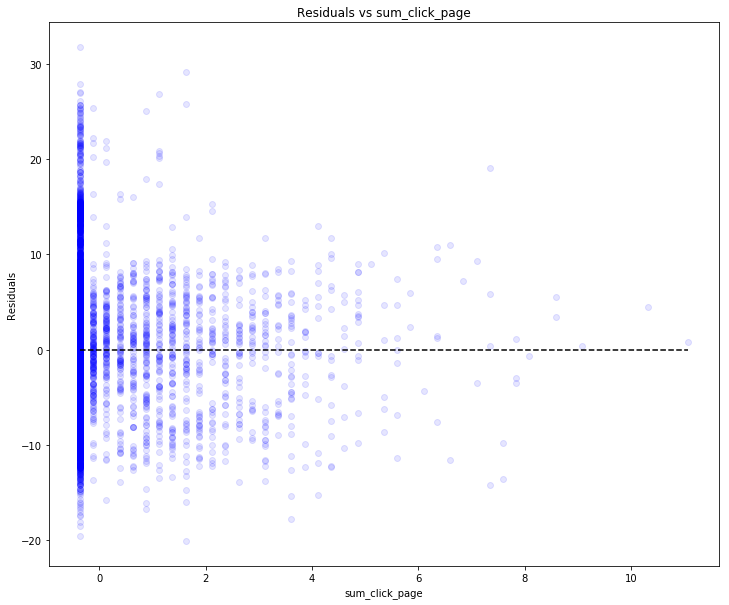

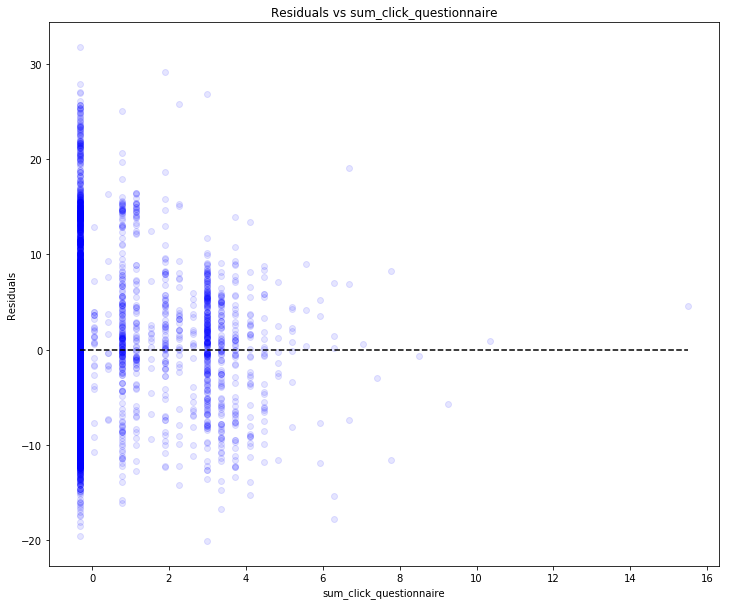

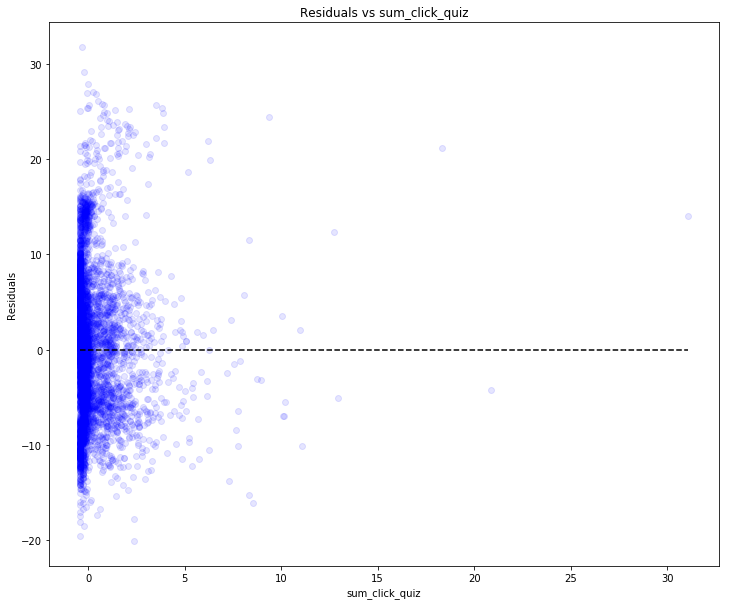

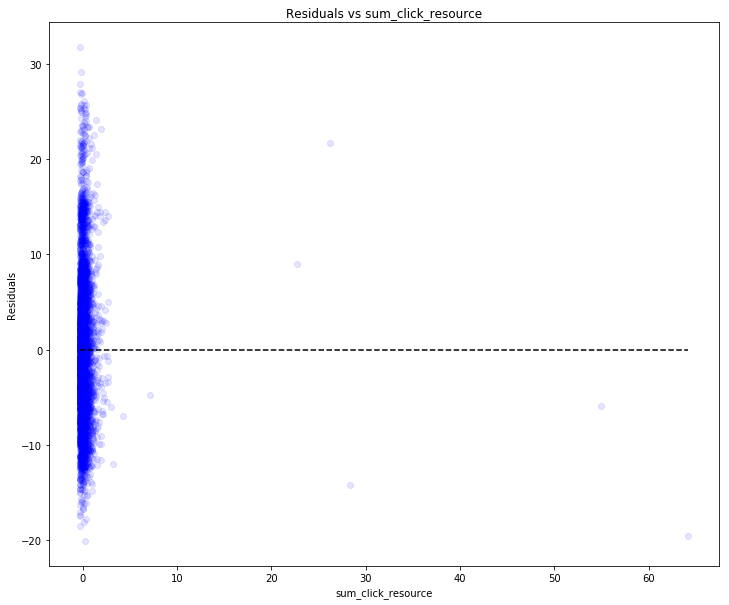

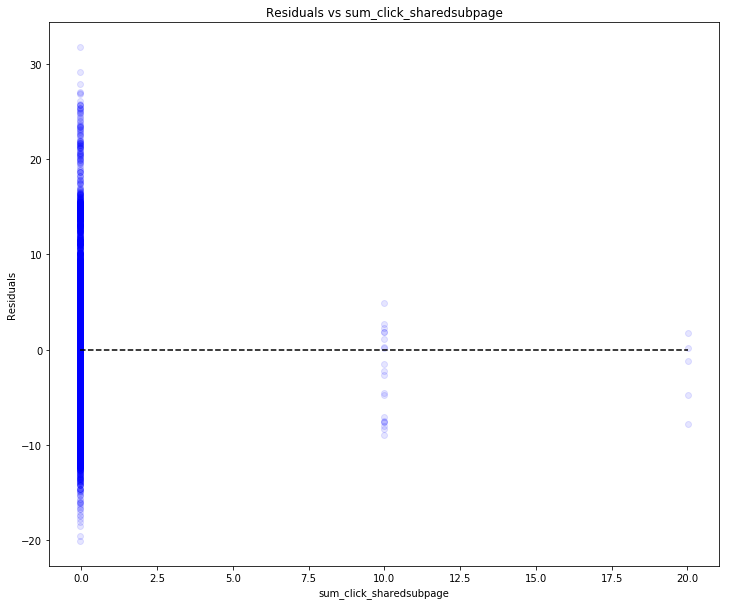

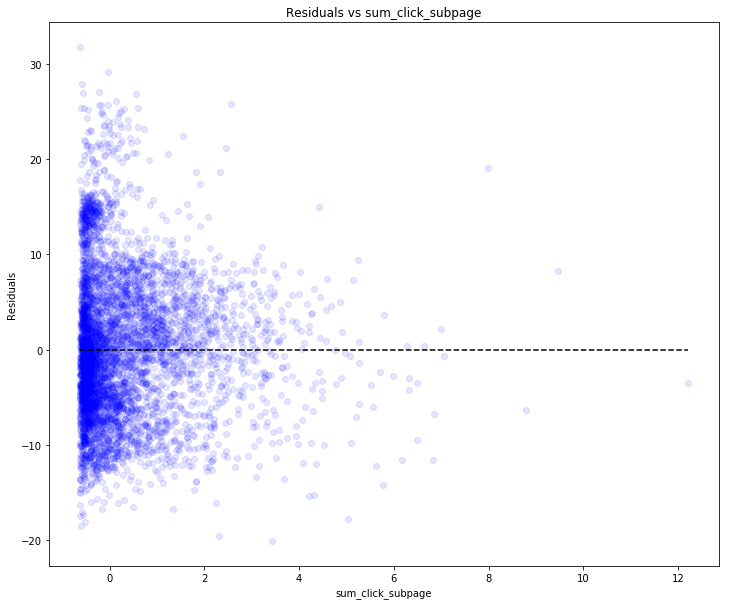

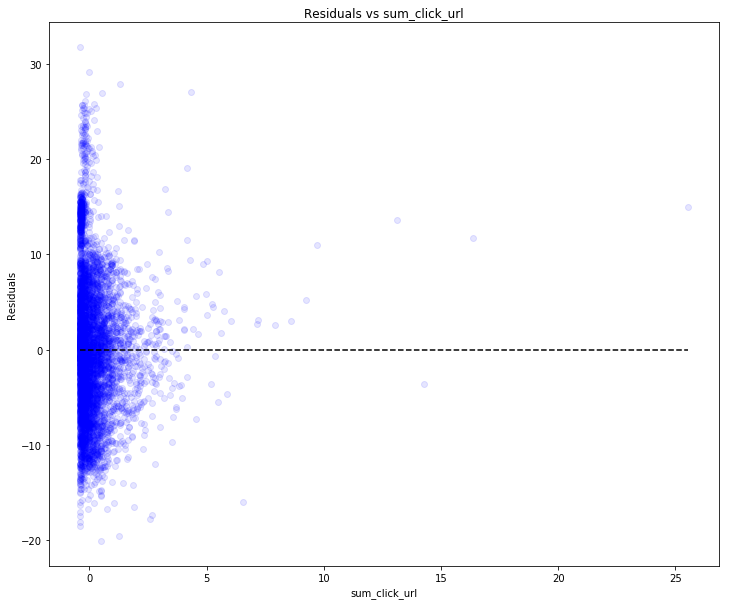

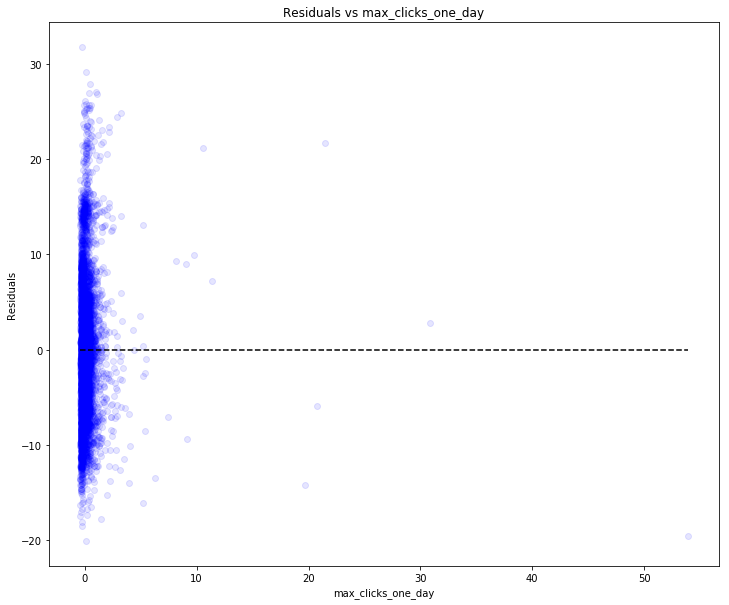

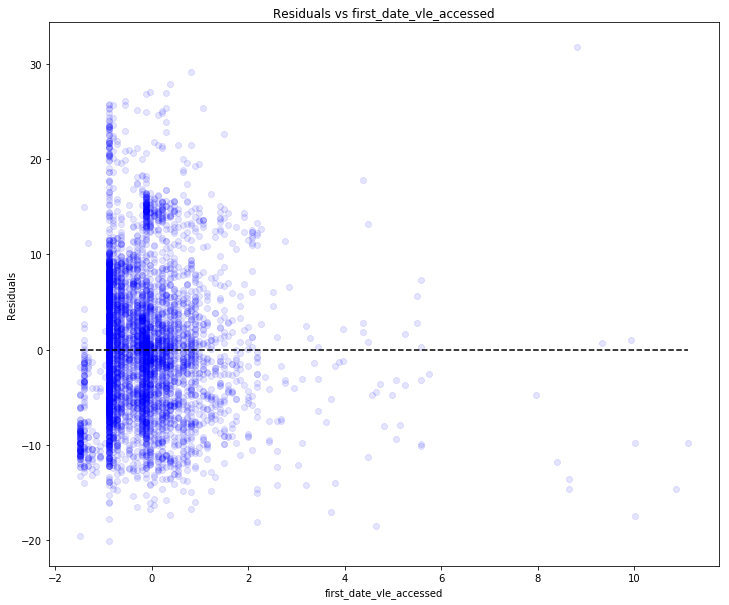

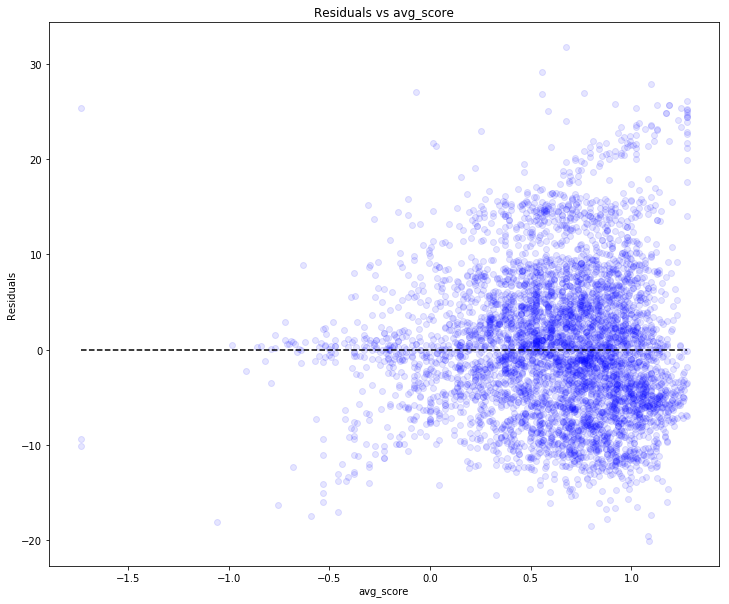

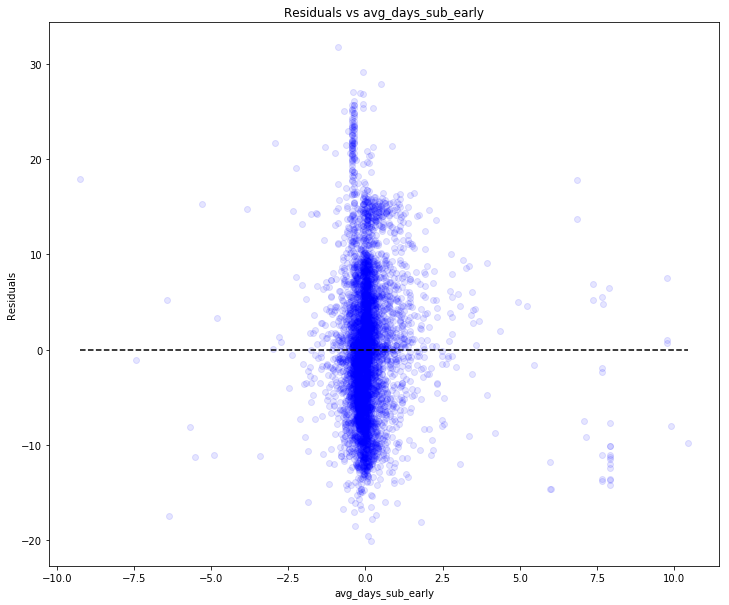

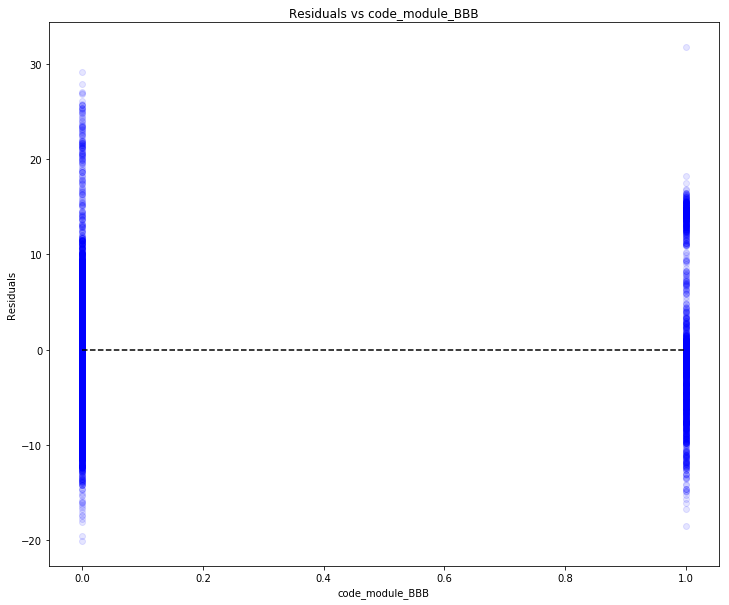

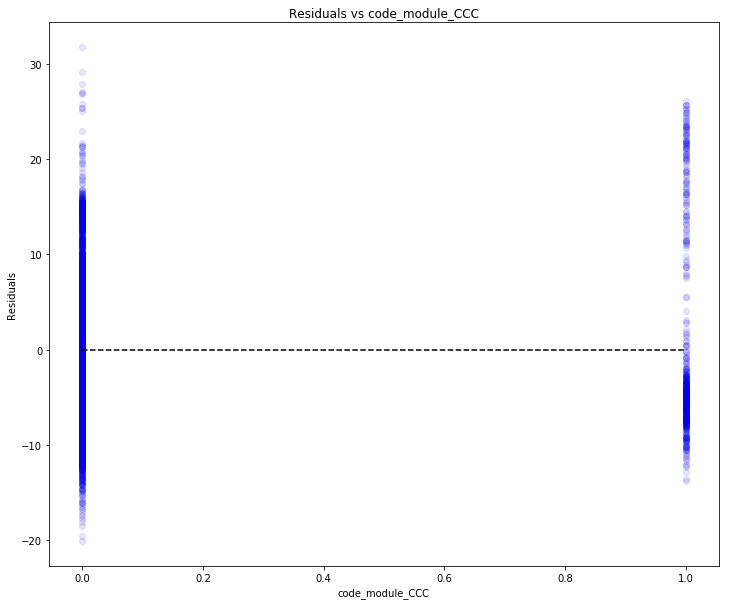

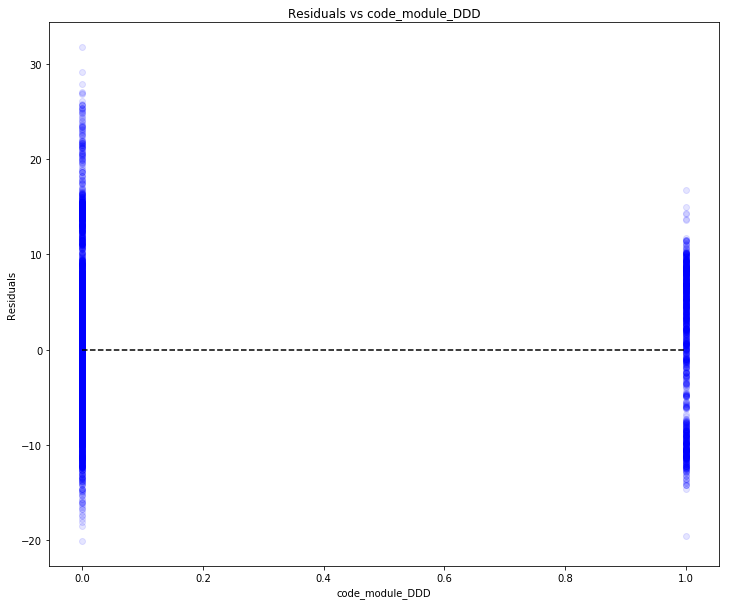

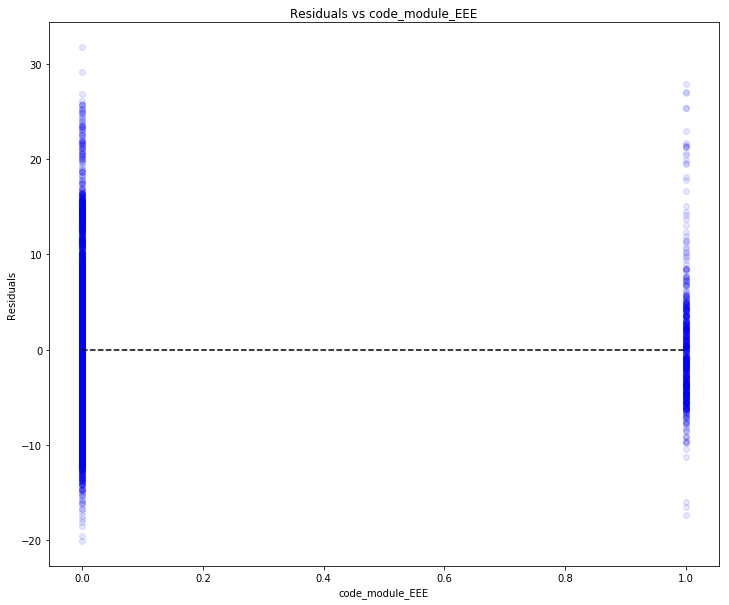

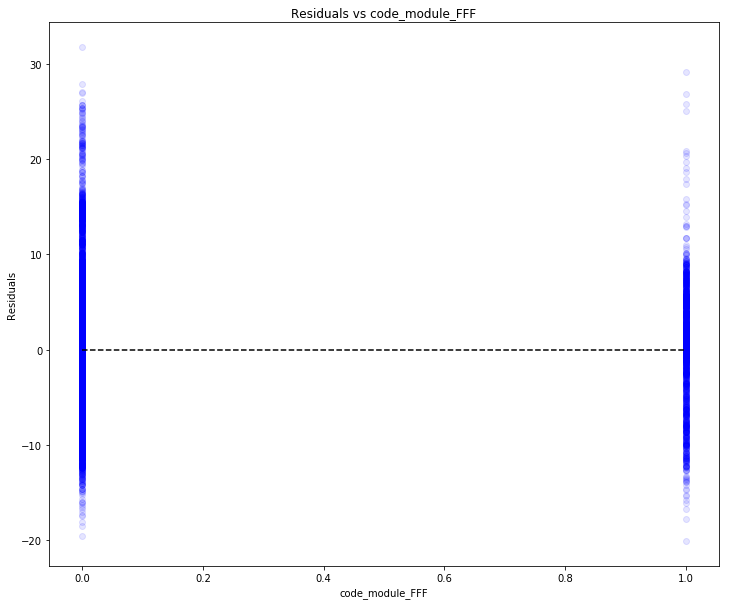

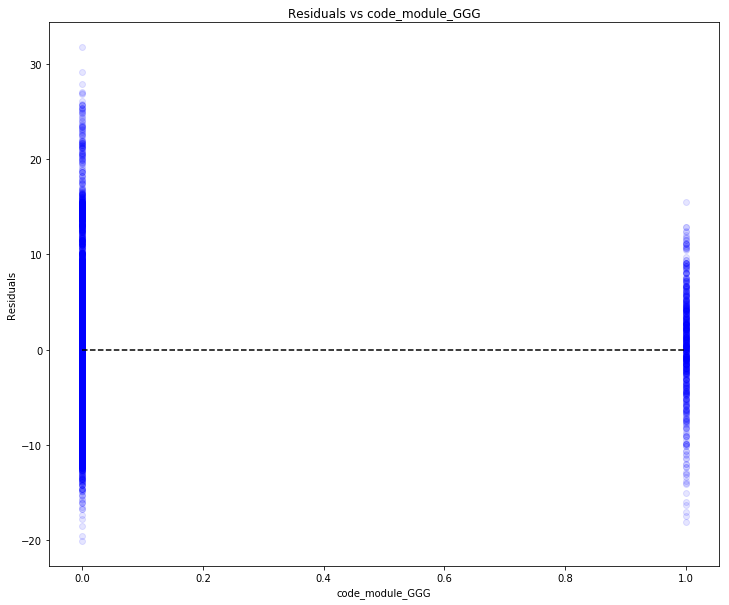

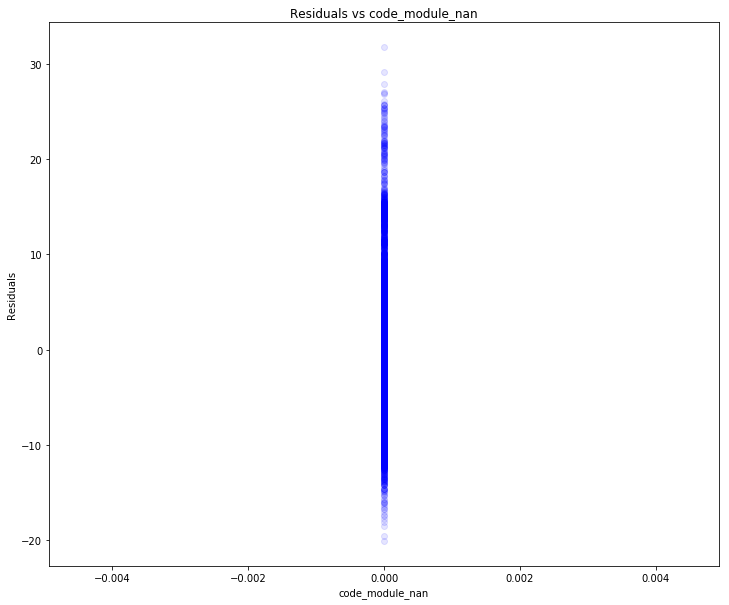

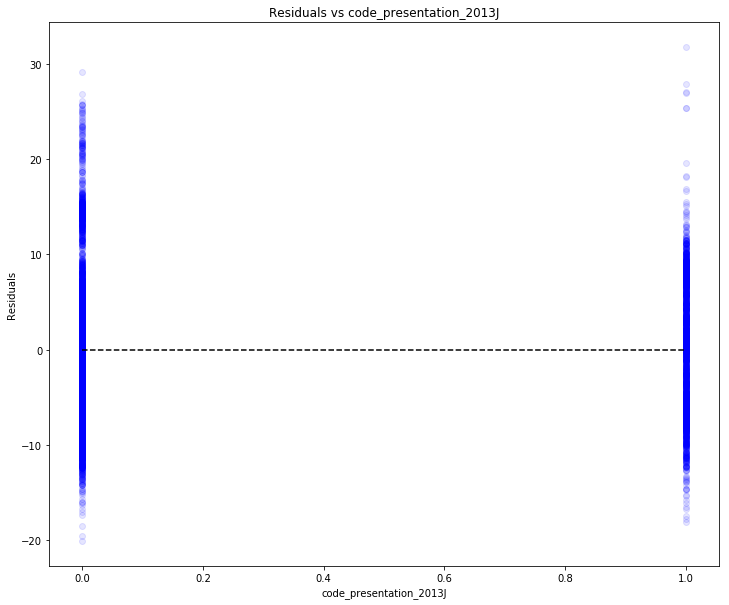

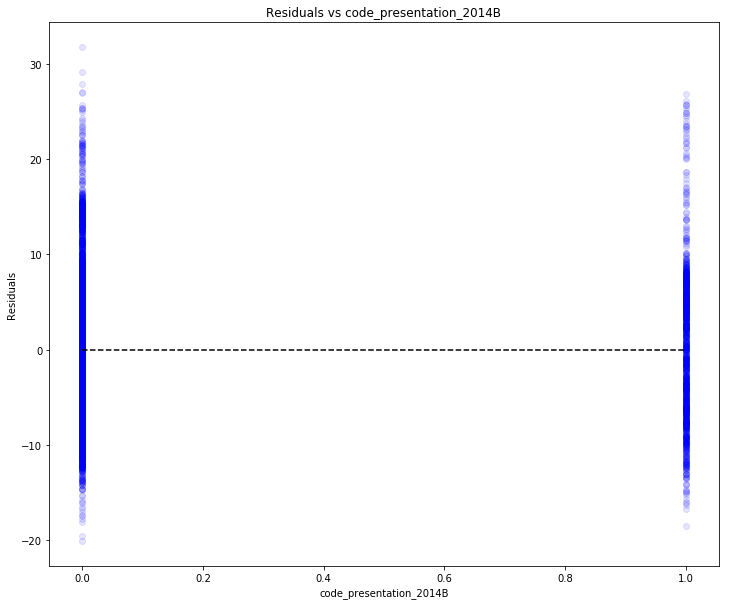

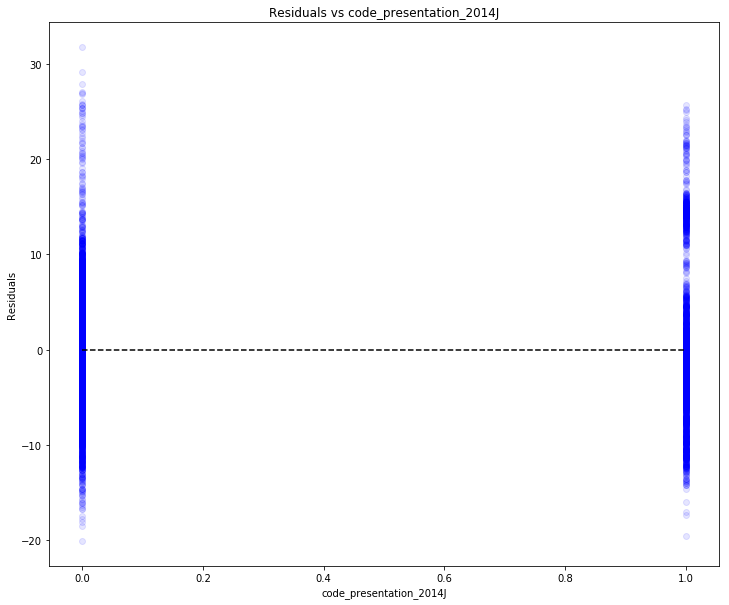

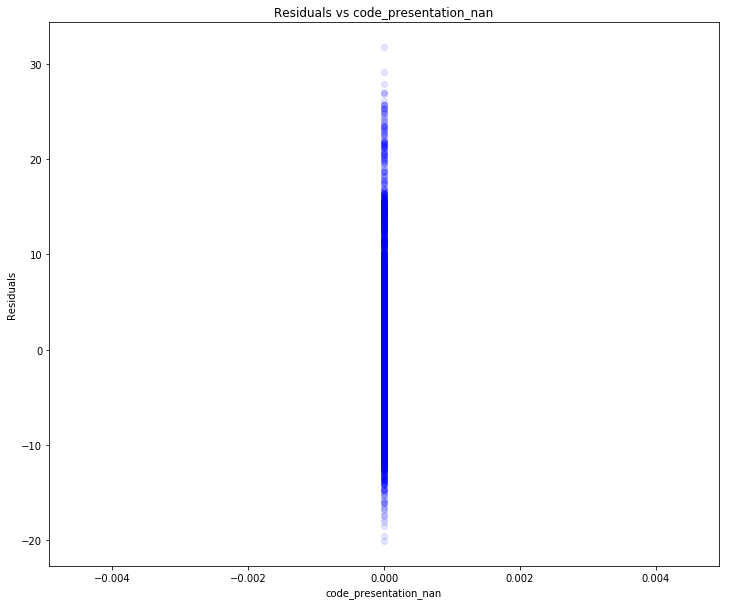

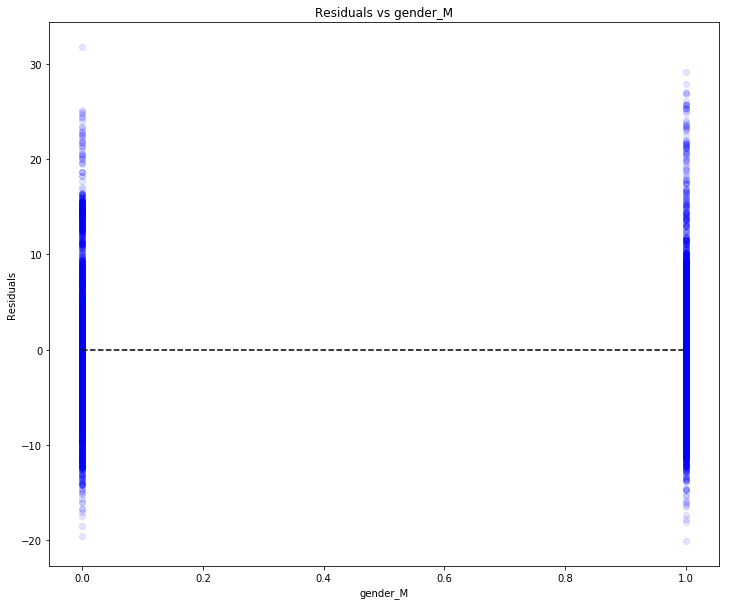

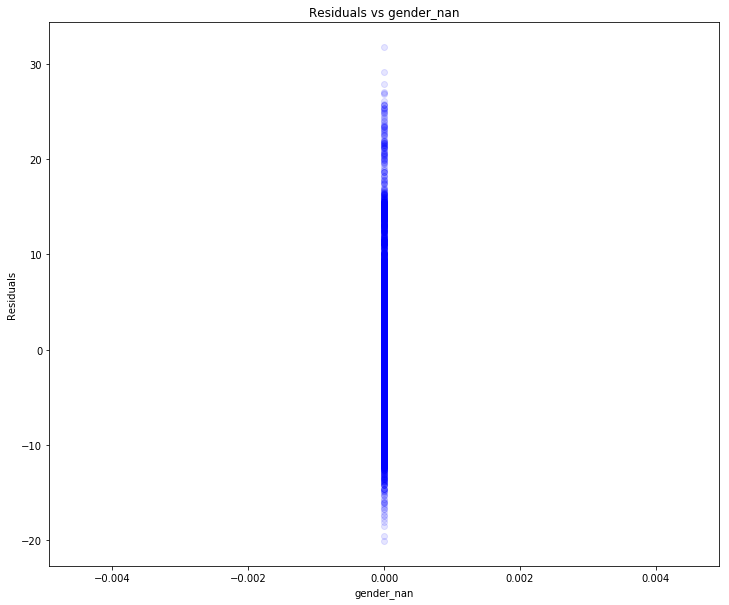

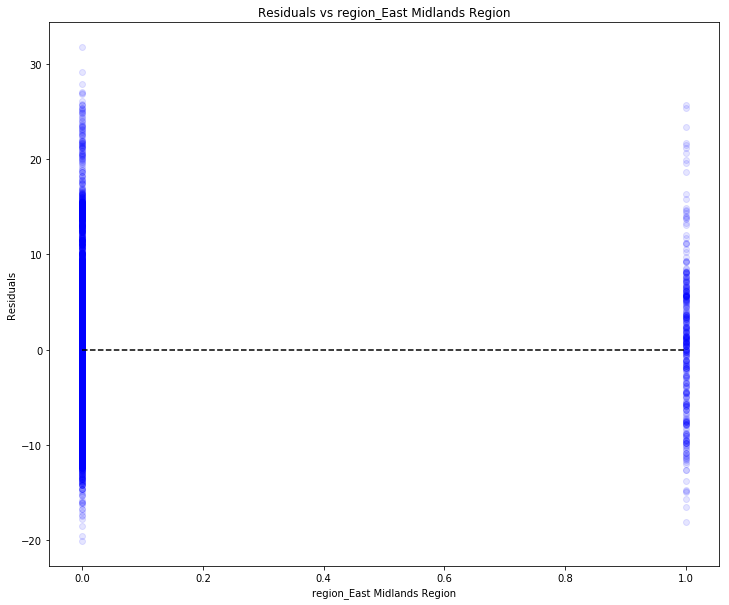

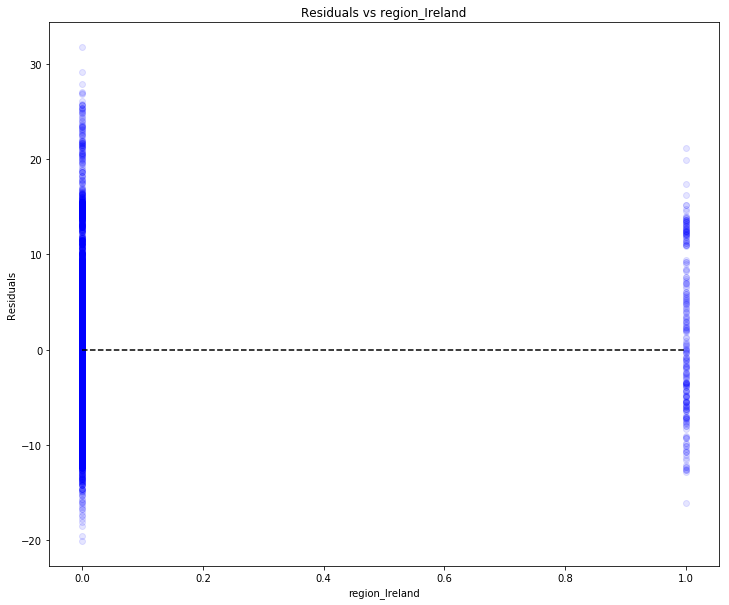

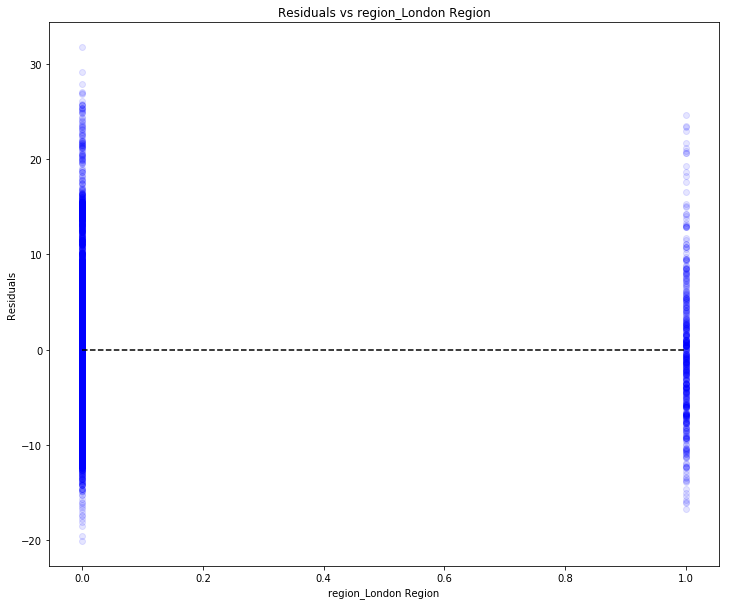

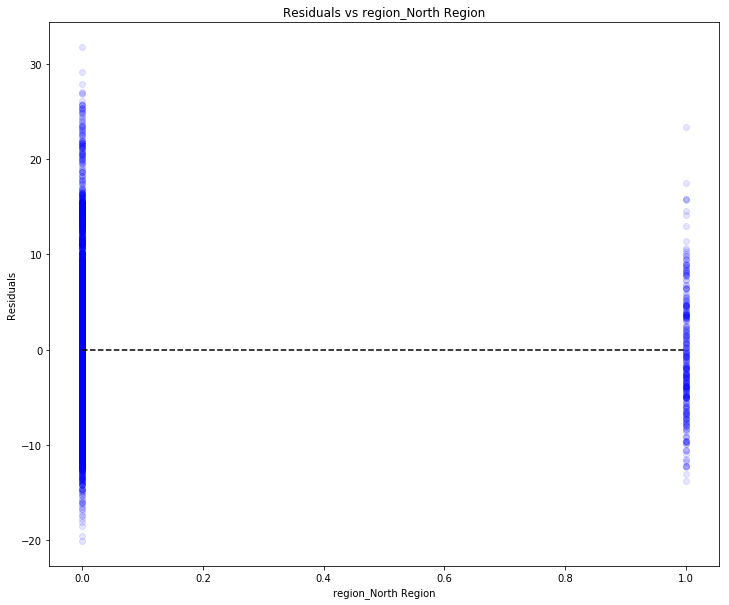

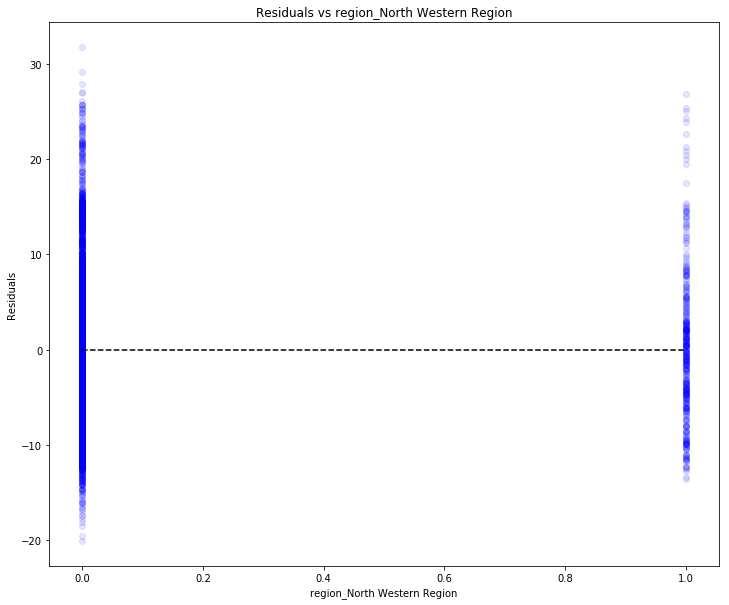

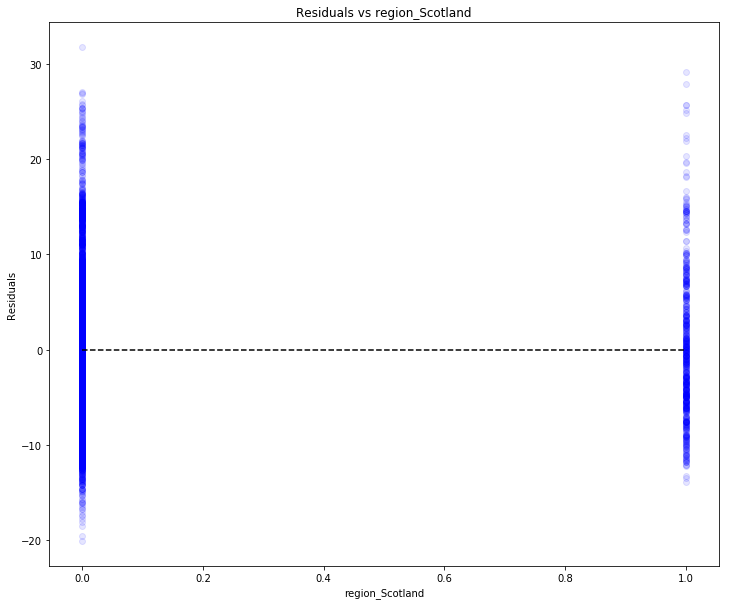

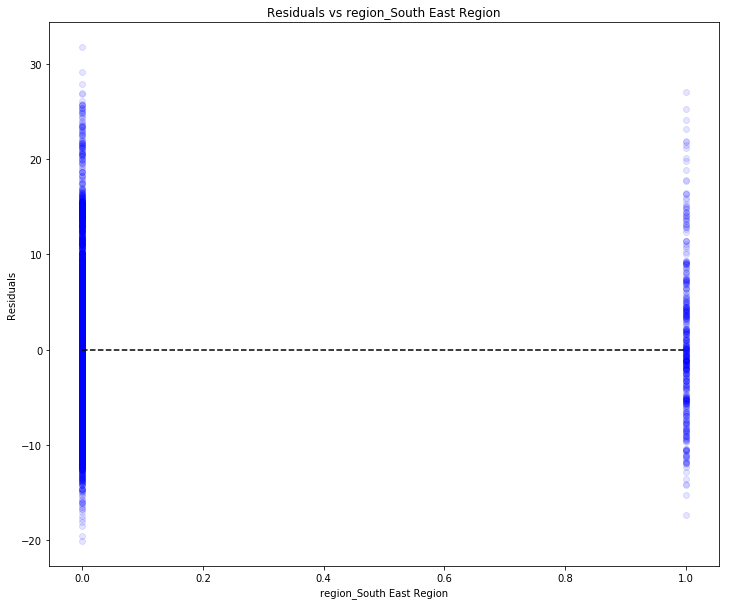

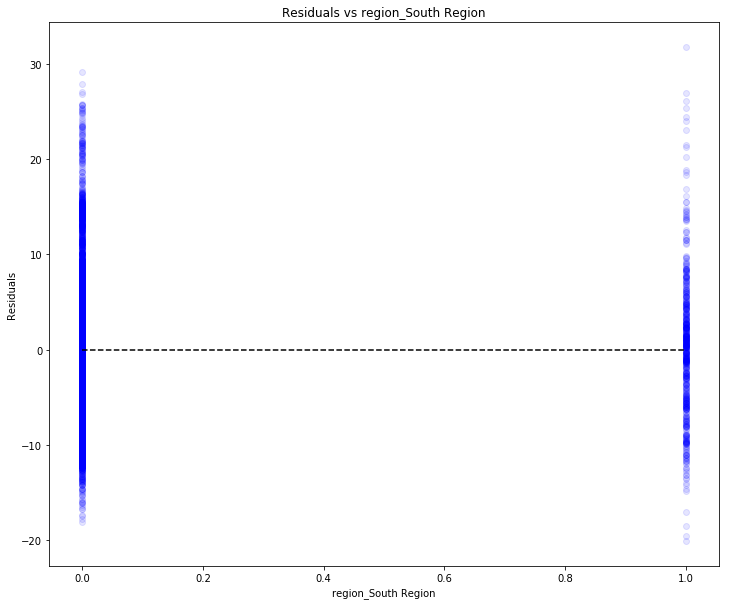

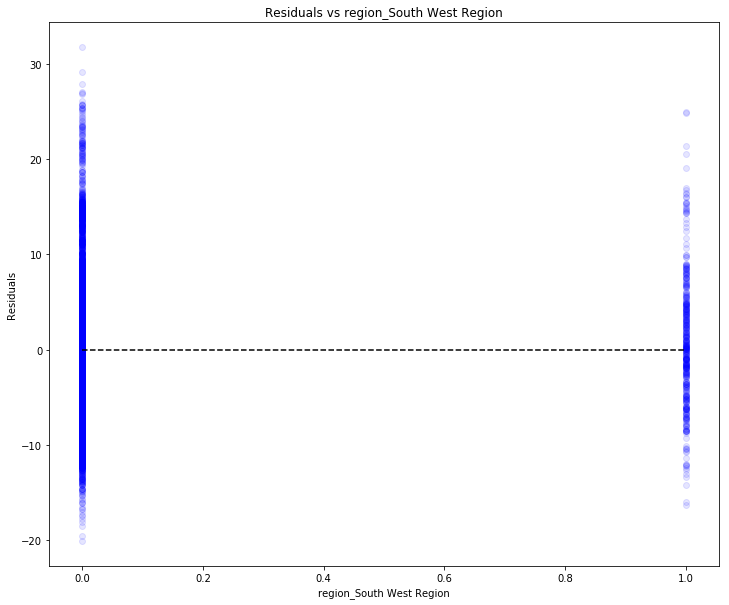

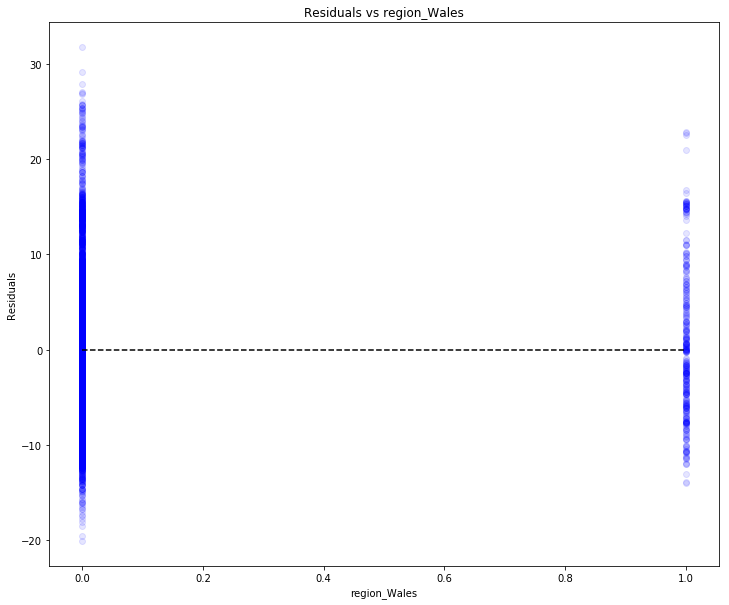

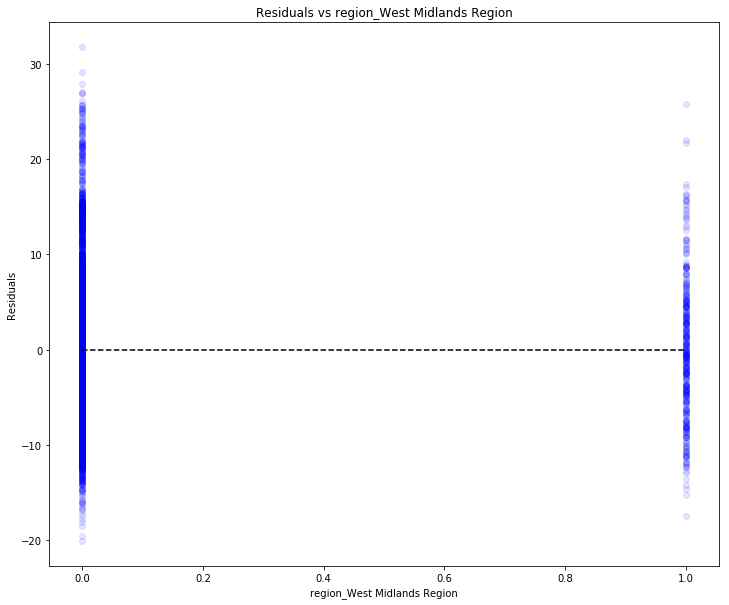

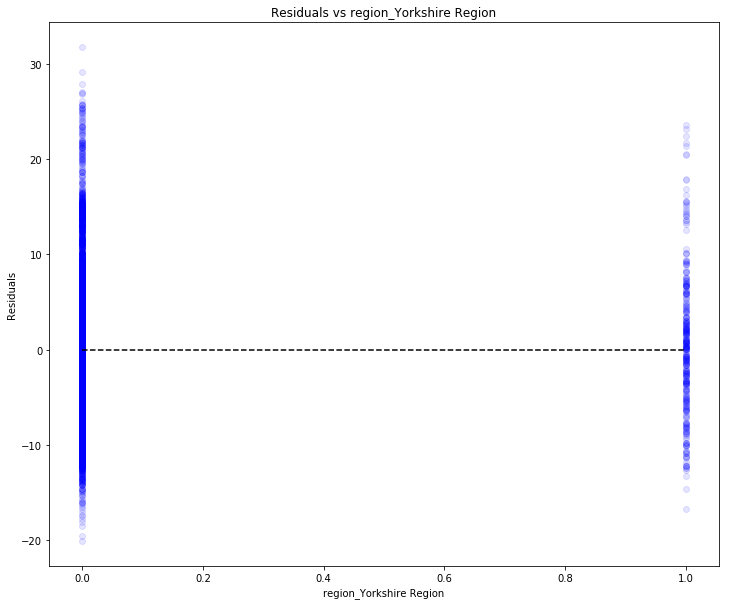

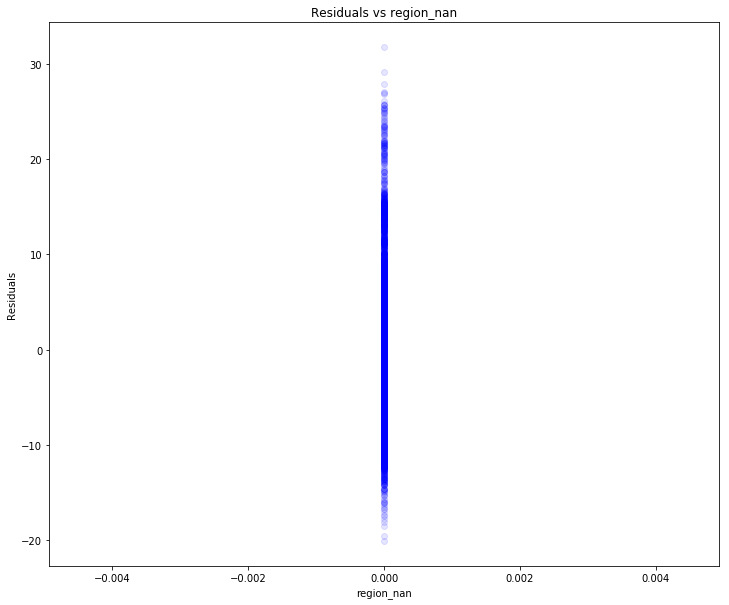

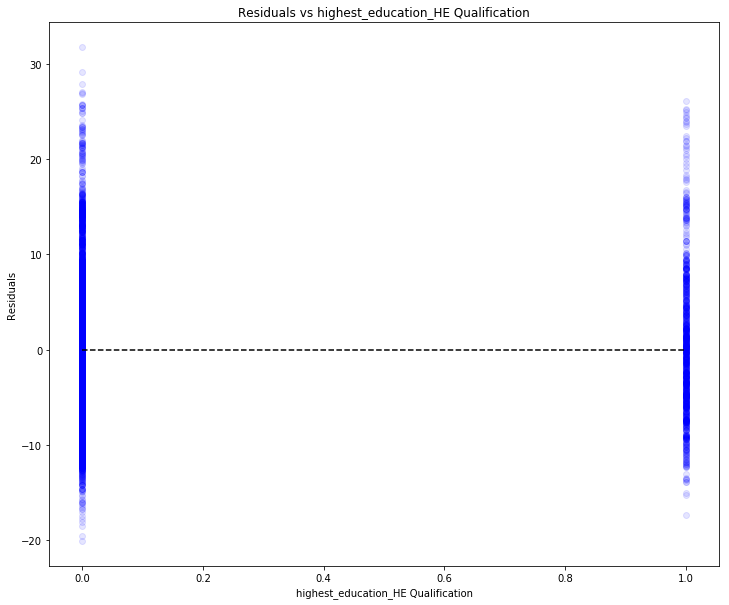

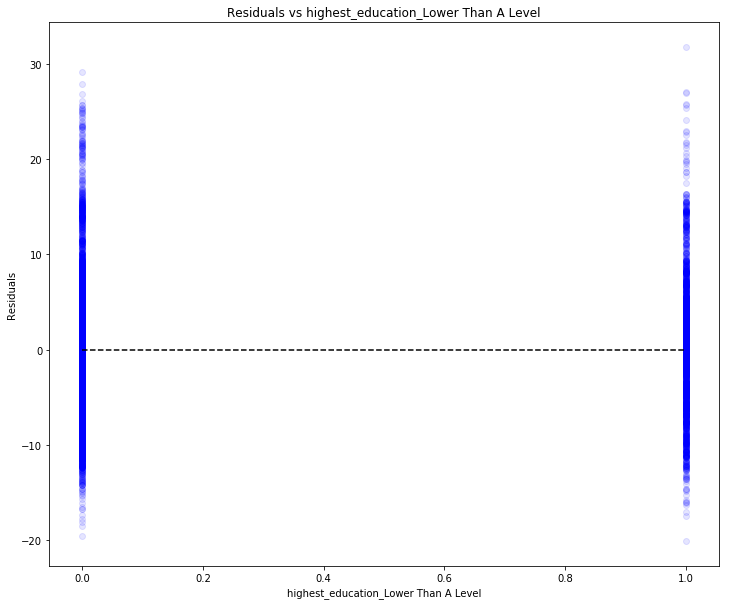

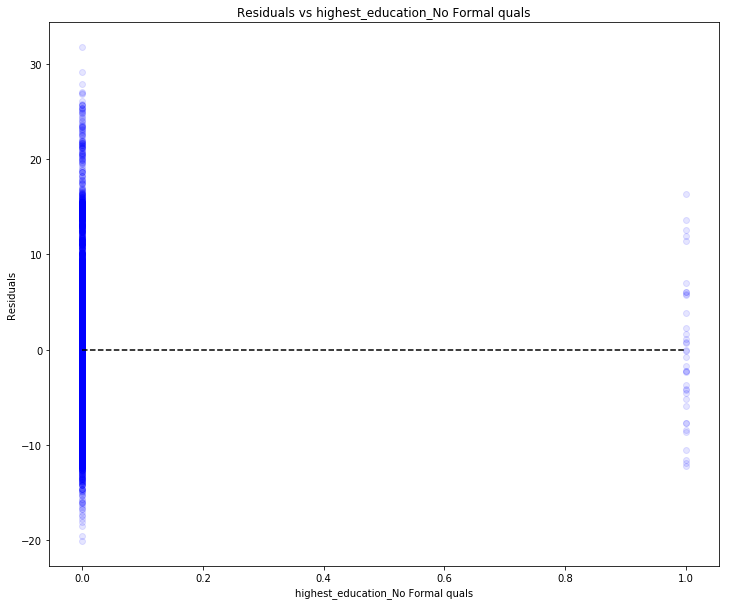

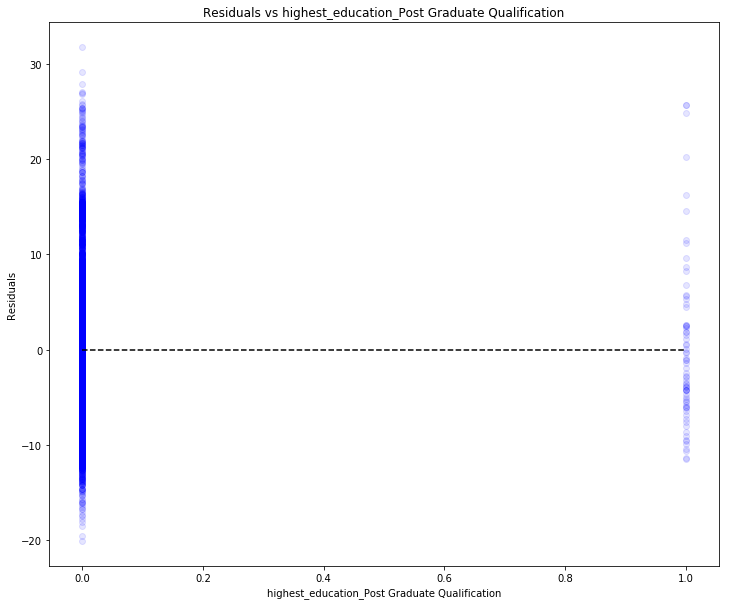

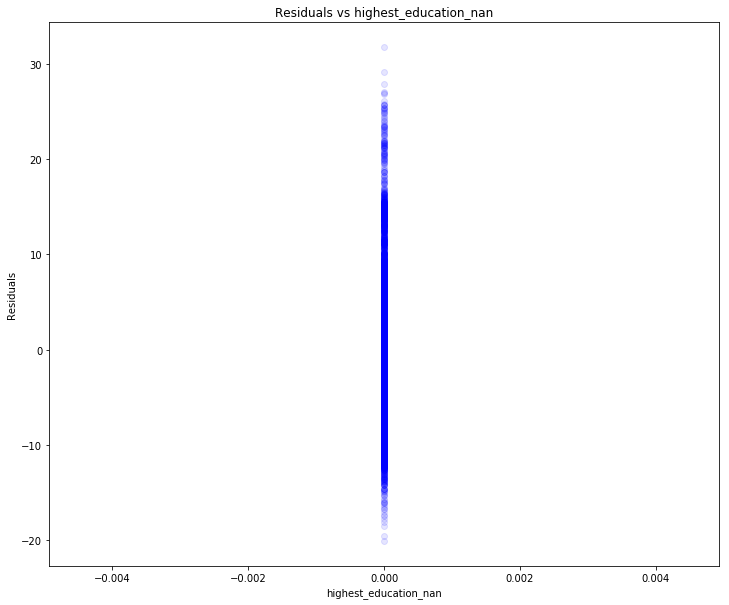

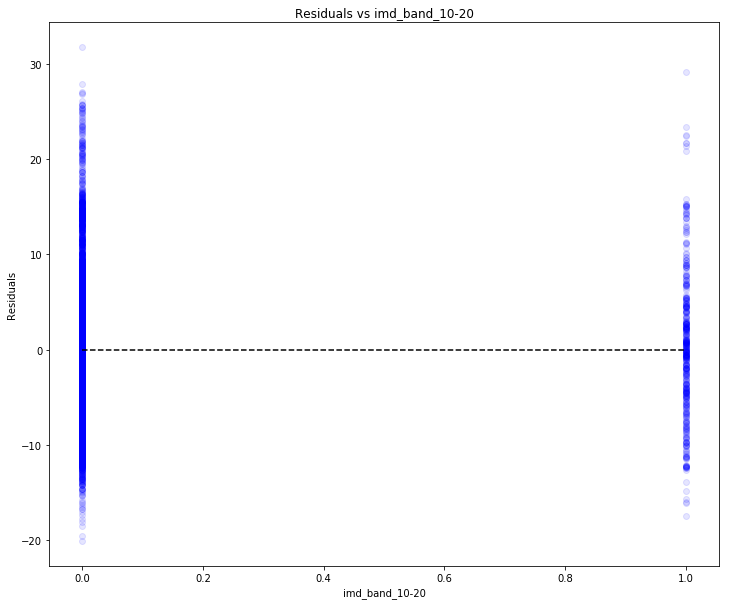

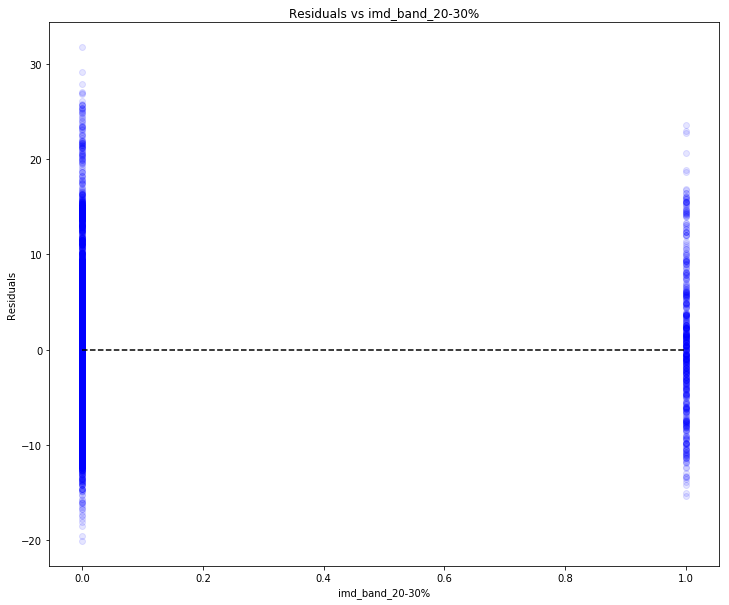

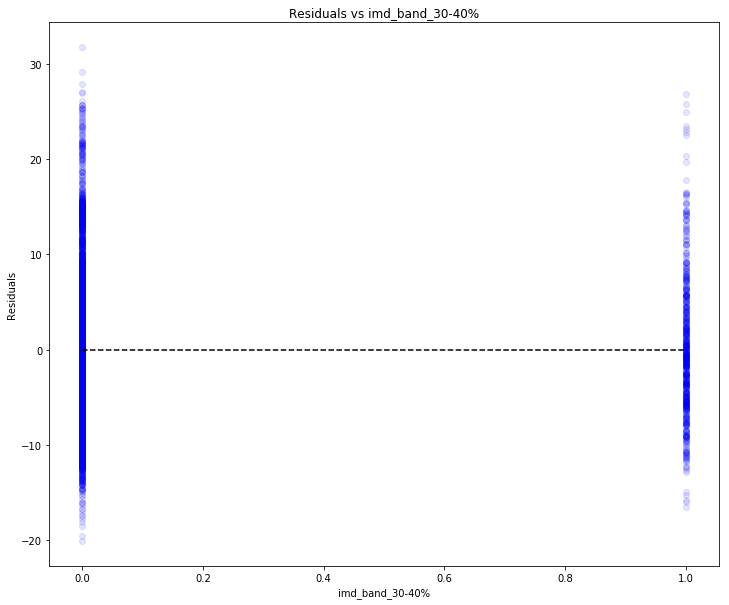

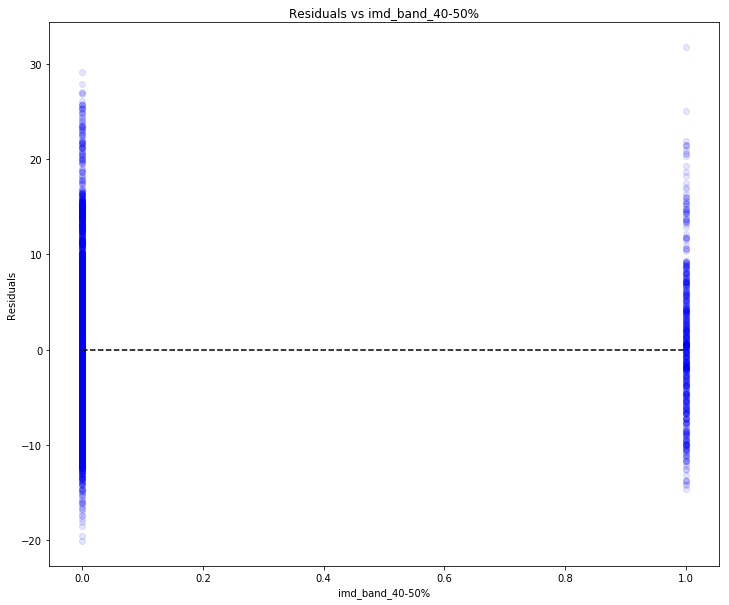

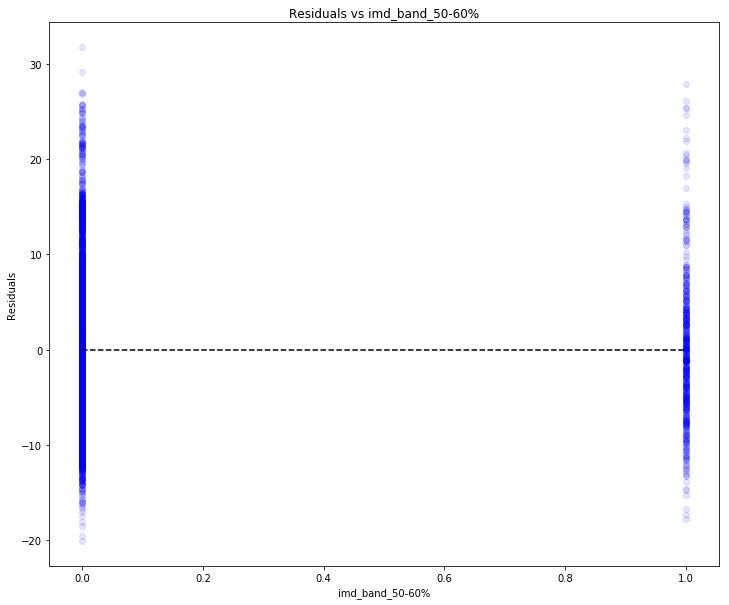

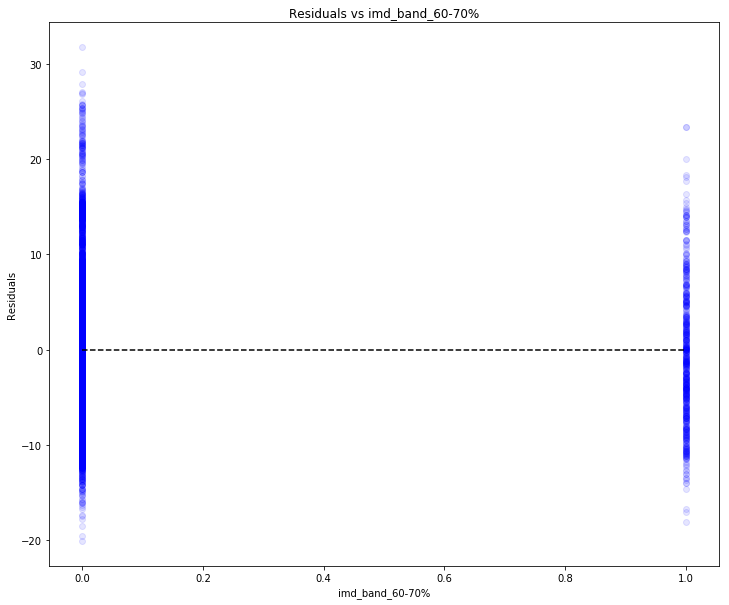

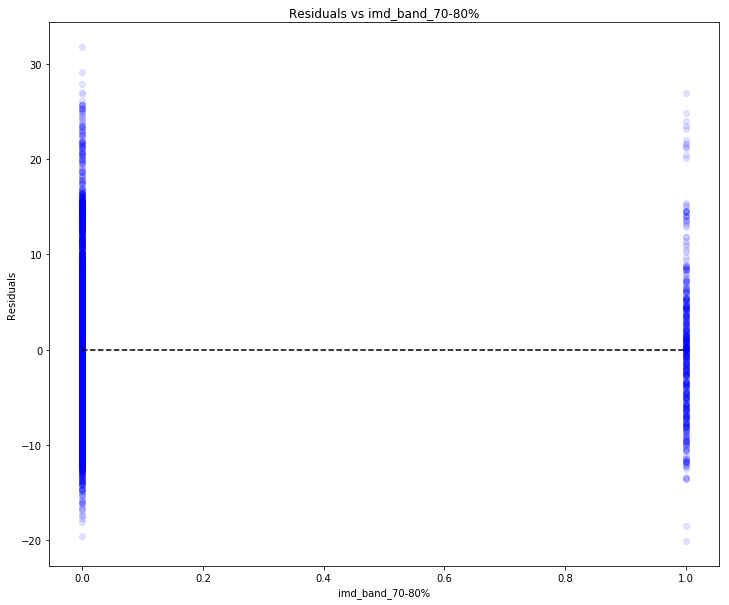

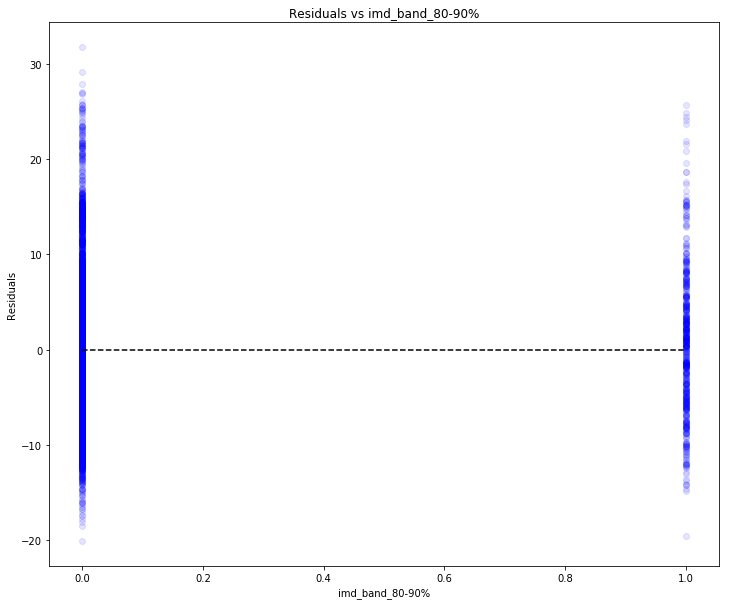

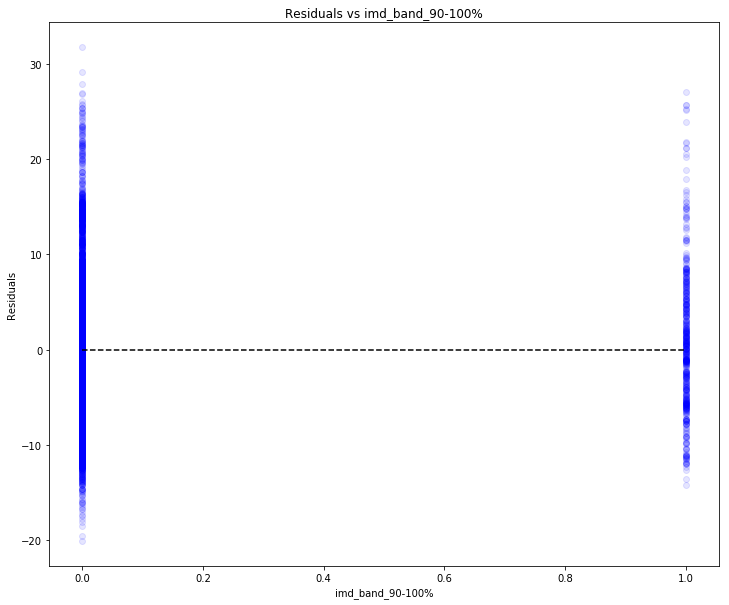

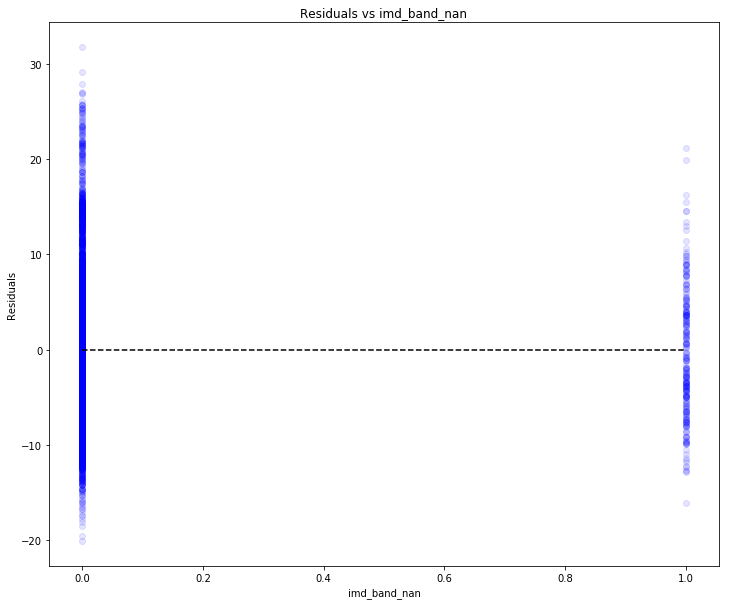

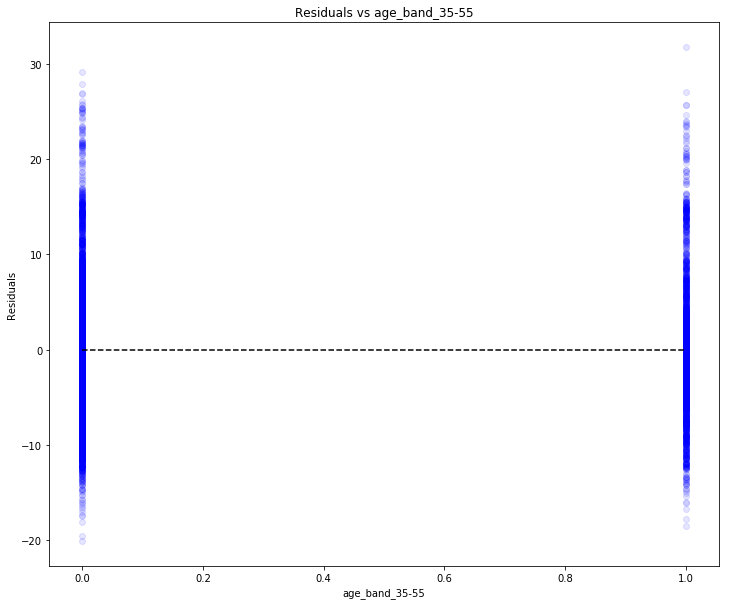

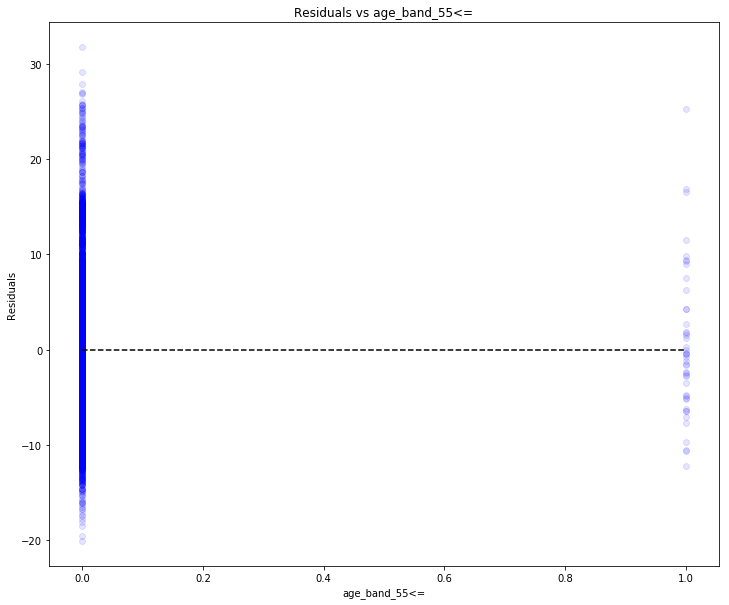

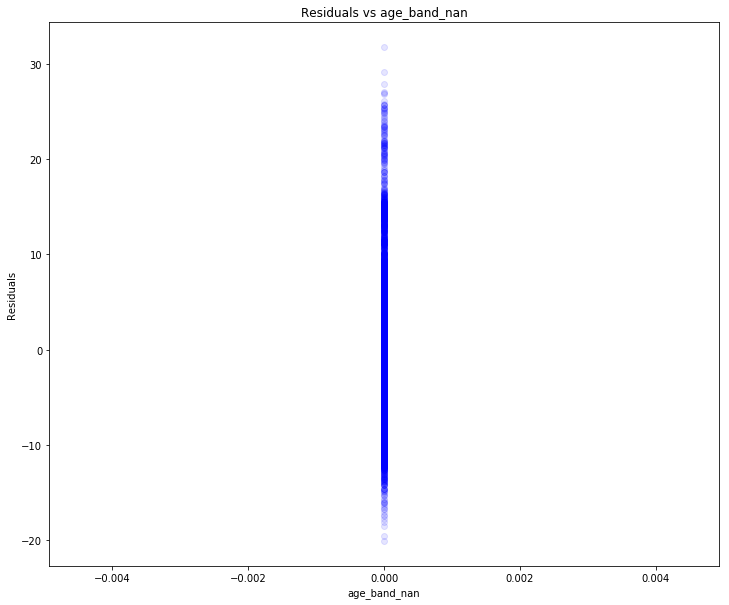

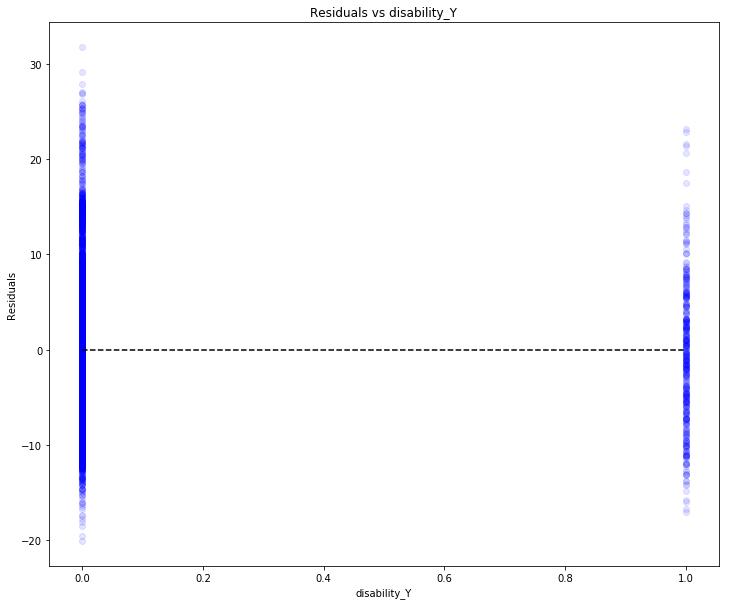

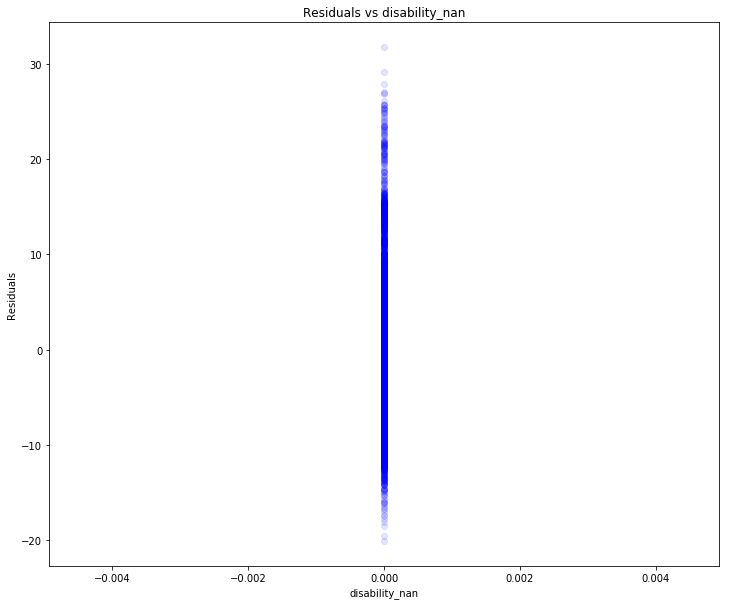

In [44]:
plot_residuals(residuals, y_test, X_test.columns, X_test)